## Gruppenprojekt Marketing Analytics

Eingereicht von Roya Abdel Nasser, Karar Ghawami, Alexandra Gohr & Natalie Schwientek

In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

import pandas as pd
from pandas.api.types import CategoricalDtype

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

import sktime
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.base import ForecastingHorizon

from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.model_selection import ForecastingGridSearchCV
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.forecasting.model_evaluation import evaluate
#from sktime.performance_metrics.forecasting import MeanAbsoluteError
#from sktime.performance_metrics.forecasting import MeanSquaredError

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import STL

import zipfile

%matplotlib inline
sns.set(rc={'figure.figsize':(18,8)})
pd.options.display.max_columns = 999

In [2]:
#Größe der Graphiken festlegen
from matplotlib.pyplot import figure
figure(figsize=(18, 8), dpi=80)

<Figure size 1440x640 with 0 Axes>

<Figure size 1440x640 with 0 Axes>

### 1. Data Preparation

In [3]:
#Datentypen für das Einlesen der Datensätze definieren
dtypes_calendar_data = {
    'weekd_id' : 'int',
    'event_type_1' : 'category',
    'event_type_2' : 'category'
}

dtypes_prices_data = {
    'week_id' : 'int',
    'item_id' : 'category',
    'price' : 'float64'  
}

dtypes_sales_data = {
    'week_id' : 'int',
    'dept_id' : 'category',
    'cat_id' : 'category',
    'sales' : 'int',
    'item_id' : 'category'
}

#Einlesen der Datensätze direkt mit den vordefinierten Datentypen
calendar_data = pd.read_csv("calendar.csv",parse_dates = ['date'], dtype = dtypes_calendar_data)
prices_data = pd.read_csv("prices.csv", dtype = dtypes_prices_data)
zf = zipfile.ZipFile('sales.zip') 
sales_data = pd.read_csv(zf.open('sales.csv'),parse_dates = ['date'], dtype = dtypes_sales_data)

#Datensätze ausgeben
display(calendar_data.head())
display(calendar_data.info())
display(prices_data.head())
display(prices_data.info())
display(sales_data.tail())
display(sales_data.info())

,date,week_id,event_name_1,event_type_1,event_name_2,event_type_2,snap
0,2011-02-01,11101,NaN,NaN,NaN,NaN,1
1,2011-02-02,11101,NaN,NaN,NaN,NaN,1
2,2011-02-03,11101,NaN,NaN,NaN,NaN,1
3,2011-02-04,11101,NaN,NaN,NaN,NaN,1
4,2011-02-05,11102,NaN,NaN,NaN,NaN,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1886 entries, 0 to 1885
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          1886 non-null   datetime64[ns]
 1   week_id       1886 non-null   int64         
 2   event_name_1  154 non-null    object        
 3   event_type_1  154 non-null    category      
 4   event_name_2  4 non-null      object        
 5   event_type_2  4 non-null      category      
 6   snap          1886 non-null   int64         
dtypes: category(2), datetime64[ns](1), int64(2), object(2)
memory usage: 77.7+ KB


None

,Unnamed: 0,item_id,week_id,price
0,0,HOBBIES_1_001,11325,9.58
1,1,HOBBIES_1_001,11326,9.58
2,2,HOBBIES_1_001,11327,8.26
3,3,HOBBIES_1_001,11328,8.26
4,4,HOBBIES_1_001,11329,8.26


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661824 entries, 0 to 661823
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   Unnamed: 0  661824 non-null  int64   
 1   item_id     661824 non-null  category
 2   week_id     661824 non-null  int32   
 3   price       661824 non-null  float64 
dtypes: category(1), float64(1), int32(1), int64(1)
memory usage: 14.0 MB


None

,date,item_id,dept_id,cat_id,sales
5655890,2016-02-29,FOODS_3_823,FOODS_3,FOODS,2
5655891,2016-02-29,FOODS_3_824,FOODS_3,FOODS,0
5655892,2016-02-29,FOODS_3_825,FOODS_3,FOODS,0
5655893,2016-02-29,FOODS_3_826,FOODS_3,FOODS,1
5655894,2016-02-29,FOODS_3_827,FOODS_3,FOODS,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5655895 entries, 0 to 5655894
Data columns (total 5 columns):
 #   Column   Dtype         
---  ------   -----         
 0   date     datetime64[ns]
 1   item_id  category      
 2   dept_id  category      
 3   cat_id   category      
 4   sales    int32         
dtypes: category(3), datetime64[ns](1), int32(1)
memory usage: 86.4 MB


None

In [4]:
#Datensätze zusammenführen
merged_data = pd.merge(sales_data, calendar_data, on= "date")
merged_data.head()

full_data = pd.merge(merged_data, prices_data, on= ["week_id", "item_id"])

display(full_data.info())
display(full_data.head(100))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4531588 entries, 0 to 4531587
Data columns (total 13 columns):
 #   Column        Dtype         
---  ------        -----         
 0   date          datetime64[ns]
 1   item_id       category      
 2   dept_id       category      
 3   cat_id        category      
 4   sales         int32         
 5   week_id       int64         
 6   event_name_1  object        
 7   event_type_1  category      
 8   event_name_2  object        
 9   event_type_2  category      
 10  snap          int64         
 11  Unnamed: 0    int64         
 12  price         float64       
dtypes: category(5), datetime64[ns](1), float64(1), int32(1), int64(3), object(2)
memory usage: 319.9+ MB


None

,date,item_id,dept_id,cat_id,sales,week_id,event_name_1,event_type_1,event_name_2,event_type_2,snap,Unnamed: 0,price
0,2011-02-01,HOBBIES_1_008,HOBBIES_1,HOBBIES,0,11101,NaN,NaN,NaN,NaN,1,1512,0.46
1,2011-02-02,HOBBIES_1_008,HOBBIES_1,HOBBIES,0,11101,NaN,NaN,NaN,NaN,1,1512,0.46
2,2011-02-03,HOBBIES_1_008,HOBBIES_1,HOBBIES,4,11101,NaN,NaN,NaN,NaN,1,1512,0.46
3,2011-02-04,HOBBIES_1_008,HOBBIES_1,HOBBIES,6,11101,NaN,NaN,NaN,NaN,1,1512,0.46
4,2011-02-01,HOBBIES_1_009,HOBBIES_1,HOBBIES,3,11101,NaN,NaN,NaN,NaN,1,1794,1.56
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2011-02-04,HOBBIES_1_076,HOBBIES_1,HOBBIES,1,11101,NaN,NaN,NaN,NaN,1,17276,2.94
96,2011-02-01,HOBBIES_1_078,HOBBIES_1,HOBBIES,0,11101,NaN,NaN,NaN,NaN,1,17781,11.97
97,2011-02-02,HOBBIES_1_078,HOBBIES_1,HOBBIES,0,11101,NaN,NaN,NaN,NaN,1,17781,11.97
98,2011-02-03,HOBBIES_1_078,HOBBIES_1,HOBBIES,0,11101,NaN,NaN,NaN,NaN,1,17781,11.97


In [5]:
full_data.set_index(['date'], inplace = True)
full_data.sort_index(axis = 0, ascending = True, inplace = True)
full_data_clean = full_data.drop("Unnamed: 0", axis=1)
full_data_clean.head(10)

,item_id,dept_id,cat_id,sales,week_id,event_name_1,event_type_1,event_name_2,event_type_2,snap,price
date,,,,,,,,,,,
2011-02-01,HOBBIES_1_008,HOBBIES_1,HOBBIES,0,11101,NaN,NaN,NaN,NaN,1,0.46
2011-02-01,FOODS_3_535,FOODS_3,FOODS,2,11101,NaN,NaN,NaN,NaN,1,6.68
2011-02-01,HOUSEHOLD_2_292,HOUSEHOLD_2,HOUSEHOLD,0,11101,NaN,NaN,NaN,NaN,1,14.97
2011-02-01,HOUSEHOLD_2_288,HOUSEHOLD_2,HOUSEHOLD,0,11101,NaN,NaN,NaN,NaN,1,3.67
2011-02-01,HOUSEHOLD_2_287,HOUSEHOLD_2,HOUSEHOLD,1,11101,NaN,NaN,NaN,NaN,1,1.87
2011-02-01,HOUSEHOLD_2_285,HOUSEHOLD_2,HOUSEHOLD,1,11101,NaN,NaN,NaN,NaN,1,4.67
2011-02-01,FOODS_3_536,FOODS_3,FOODS,4,11101,NaN,NaN,NaN,NaN,1,2.48
2011-02-01,HOUSEHOLD_2_284,HOUSEHOLD_2,HOUSEHOLD,0,11101,NaN,NaN,NaN,NaN,1,6.47
2011-02-01,HOUSEHOLD_2_283,HOUSEHOLD_2,HOUSEHOLD,0,11101,NaN,NaN,NaN,NaN,1,5.47


Als zusätziche erklärende Variablen werden der jeweilige Name und Wochentag eingefügt. Um die einzelnen Variaben in die Modelle einfließen lassen zu können, werden diese binär kodiert und zu Dummy-Variablen transformiert

In [6]:
#Dummy-variablen codieren
full_data_clean['Month'] = full_data_clean.index.month_name()
full_data_clean['Weekday'] = full_data_clean.index.day_name()
data = pd.get_dummies(full_data_clean, columns = ['event_name_1','event_type_1','event_name_2','event_type_2', 'Month', 'Weekday'], drop_first = False)
data.head()

,item_id,dept_id,cat_id,sales,week_id,snap,price,event_name_1_Chanukah End,event_name_1_Christmas,event_name_1_Cinco De Mayo,event_name_1_ColumbusDay,event_name_1_Easter,event_name_1_Eid al-Fitr,event_name_1_EidAlAdha,event_name_1_Father's day,event_name_1_Halloween,event_name_1_IndependenceDay,event_name_1_LaborDay,event_name_1_LentStart,event_name_1_LentWeek2,event_name_1_MartinLutherKingDay,event_name_1_MemorialDay,event_name_1_Mother's day,event_name_1_NBAFinalsEnd,event_name_1_NBAFinalsStart,event_name_1_NewYear,event_name_1_OrthodoxChristmas,event_name_1_OrthodoxEaster,event_name_1_Pesach End,event_name_1_PresidentsDay,event_name_1_Purim End,event_name_1_Ramadan starts,event_name_1_StPatricksDay,event_name_1_SuperBowl,event_name_1_Thanksgiving,event_name_1_ValentinesDay,event_name_1_VeteransDay,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_name_2_Cinco De Mayo,event_name_2_Easter,event_name_2_Father's day,event_name_2_OrthodoxEaster,event_type_2_Cultural,event_type_2_Religious,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-02-01,HOBBIES_1_008,HOBBIES_1,HOBBIES,0,11101,1,0.46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2011-02-01,FOODS_3_535,FOODS_3,FOODS,2,11101,1,6.68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2011-02-01,HOUSEHOLD_2_292,HOUSEHOLD_2,HOUSEHOLD,0,11101,1,14.97,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2011-02-01,HOUSEHOLD_2_288,HOUSEHOLD_2,HOUSEHOLD,0,11101,1,3.67,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2011-02-01,HOUSEHOLD_2_287,HOUSEHOLD_2,HOUSEHOLD,1,11101,1,1.87,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [7]:
# Daten auf Tagesbasis aggregieren
data_grouped = data.groupby('date').apply(

        lambda data: pd.Series({
            'sales':                           data.sales.sum(),
            'snap': data.snap.max(),
            
       #    'dept_id_FOODS_1' : data.dept_id_FOODS_1.max(),
        #   'dept_id_FOODS_2' : data.dept_id_FOODS_2.max(),
         #  'dept_id_FOODS_3' : data.dept_id_FOODS_3.max(),

          # 'dept_id_HOBBIES_1' : data.dept_id_HOBBIES_1.max(),
           #'dept_id_HOBBIES_2' : data.dept_id_HOBBIES_2.max(),
          
           #'dept_id_HOUSEHOLD_1' : data.dept_id_HOUSEHOLD_1.max(),
           #'dept_id_HOUSEHOLD_2' : data.dept_id_HOUSEHOLD_2.max(),
            
            'mean_price_food':      data.loc[data.cat_id == 'FOODS', 'price'].mean(),            
            'mean_price_hobbies':   data.loc[data.cat_id == 'HOBBIES', 'price'].mean(),
            'mean_price_household': data.loc[data.cat_id == 'HOUSEHOLD', 'price'].mean(),

          
            'event_type_1_Cultural' : data.event_type_1_Cultural.max(), 
            'event_type_1_National': data.event_type_1_National.max(), 
            'event_type_1_Religious': data.event_type_1_Religious.max(), 
            'event_type_1_Sporting': data.event_type_1_Sporting.max(), 
            'event_type_2_Cultural' : data.event_type_2_Cultural.max(), 
            'event_type_2_Religious': data.event_type_2_Religious.max(), 
            
            'Month_April': data.Month_April.max(),
            'Month_August': data.Month_August.max(),
            'Month_December': data.Month_December.max(),
            'Month_February': data.Month_February.max(),
            'Month_January': data.Month_January.max(),
            'Month_July': data.Month_July.max(),
            'Month_June': data.Month_June.max(),
            'Month_March': data.Month_March.max(),
            'Month_May': data.Month_May.max(),
            'Month_November': data.Month_November.max(),
            'Month_October': data.Month_October.max(),
            'Month_September': data.Month_September.max(),
            
            'Weekday_Friday':   data.Weekday_Friday.max(),
            'Weekday_Monday':   data.Weekday_Monday.max(),
            'Weekday_Saturday': data.Weekday_Saturday.max(),
            'Weekday_Sunday':   data.Weekday_Sunday.max(),
            'Weekday_Thursday': data.Weekday_Thursday.max(),
            'Weekday_Tuesday':  data.Weekday_Tuesday.max(),
            'Weekday_Wednesday':data.Weekday_Wednesday.max()
                               
       }))
data_grouped.head()

,sales,snap,mean_price_food,mean_price_hobbies,mean_price_household,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-02-01,3051.0,1.0,3.149220,4.468814,5.416099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-02-02,2630.0,1.0,3.149220,4.468814,5.416099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-02-03,3276.0,1.0,3.149220,4.468814,5.416099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2011-02-04,3450.0,1.0,3.149220,4.468814,5.416099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-05,5437.0,1.0,3.153394,4.406516,5.509579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Aufgrund der Komplexität des Datensatzes und der Unterschiede zwischen den einzelnen Kategorien wird vermutet, dass die Preise der einzelnen Departments einen hohen Einfluss auf den Absatz haben. Daher wird der ursprüngliche Datensatz für die nächsten Schritte in drei einzelne Datensätze unterteilt, um die Prognose detaillierter pro Kategorie abzubilden.

In [8]:
#Aggregation pro Kategorie
data_food = data.loc[data['cat_id'] == 'FOODS']
data_household = data.loc[data['cat_id'] == 'HOUSEHOLD']
data_hobbies = data.loc[data['cat_id'] == 'HOBBIES']

In [9]:
food_grouped = data_food.groupby('date').apply(

        lambda data_food: pd.Series({
            'sales':                           data_food.sales.sum(),
            'snap': data_food.snap.max(),
                              
            'mean_price_dept1':   data_food.loc[data_food.dept_id == 'FOODS_1', 'price'].mean(),            
            'mean_price_dept2':   data_food.loc[data_food.dept_id == 'FOODS_2', 'price'].mean(),
            'mean_price_dept3':   data_food.loc[data_food.dept_id == 'FOODS_3', 'price'].mean(),
          
            'event_type_1_Cultural' : data_food.event_type_1_Cultural.max(), 
            'event_type_1_National': data_food.event_type_1_National.max(), 
            'event_type_1_Religious': data_food.event_type_1_Religious.max(), 
            'event_type_1_Sporting': data_food.event_type_1_Sporting.max(), 
            'event_type_2_Cultural' : data_food.event_type_2_Cultural.max(), 
            'event_type_2_Religious': data_food.event_type_2_Religious.max(), 
            
            'Month_April': data_food.Month_April.max(),
            'Month_August': data_food.Month_August.max(),
            'Month_December': data_food.Month_December.max(),
            'Month_February': data_food.Month_February.max(),
            'Month_January': data_food.Month_January.max(),
            'Month_July': data_food.Month_July.max(),
            'Month_June': data_food.Month_June.max(),
            'Month_March': data_food.Month_March.max(),
            'Month_May': data_food.Month_May.max(),
            'Month_November': data_food.Month_November.max(),
            'Month_October': data_food.Month_October.max(),
            'Month_September': data_food.Month_September.max(),
            
            'Weekday_Friday':   data_food.Weekday_Friday.max(),
            'Weekday_Monday':   data_food.Weekday_Monday.max(),
            'Weekday_Saturday': data_food.Weekday_Saturday.max(),
            'Weekday_Sunday':   data_food.Weekday_Sunday.max(),
            'Weekday_Thursday': data_food.Weekday_Thursday.max(),
            'Weekday_Tuesday':  data_food.Weekday_Tuesday.max(),
            'Weekday_Wednesday':data_food.Weekday_Wednesday.max()
                               
       }))
food_grouped.head()

,sales,snap,mean_price_dept1,mean_price_dept2,mean_price_dept3,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-02-01,2258.0,1.0,2.989109,3.807460,2.828994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-02-02,2032.0,1.0,2.989109,3.807460,2.828994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-02-03,2407.0,1.0,2.989109,3.807460,2.828994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2011-02-04,2693.0,1.0,2.989109,3.807460,2.828994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-05,3962.0,1.0,3.016636,3.875838,2.797716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [10]:
hobbies_grouped = data_hobbies.groupby('date').apply(

        lambda data_hobbies: pd.Series({
            'sales':                           data_hobbies.sales.sum(),
           # 'snap': data.snap.max(),
                         
            'mean_price_dept1':   data_hobbies.loc[data_hobbies.dept_id == 'HOBBIES_1', 'price'].mean(),            
            'mean_price_dept2':   data_hobbies.loc[data_hobbies.dept_id == 'HOBBIES_2', 'price'].mean(),

            'event_type_1_Cultural' : data_hobbies.event_type_1_Cultural.max(), 
            'event_type_1_National': data_hobbies.event_type_1_National.max(), 
            'event_type_1_Religious': data_hobbies.event_type_1_Religious.max(), 
            'event_type_1_Sporting': data_hobbies.event_type_1_Sporting.max(), 
            'event_type_2_Cultural' : data_hobbies.event_type_2_Cultural.max(), 
            'event_type_2_Religious': data_hobbies.event_type_2_Religious.max(), 
            
            'Month_April': data_hobbies.Month_April.max(),
            'Month_August': data_hobbies.Month_August.max(),
            'Month_December': data_hobbies.Month_December.max(),
            'Month_February': data_hobbies.Month_February.max(),
            'Month_January': data_hobbies.Month_January.max(),
            'Month_July': data_hobbies.Month_July.max(),
            'Month_June': data_hobbies.Month_June.max(),
            'Month_March': data_hobbies.Month_March.max(),
            'Month_May': data_hobbies.Month_May.max(),
            'Month_November': data_hobbies.Month_November.max(),
            'Month_October': data_hobbies.Month_October.max(),
            'Month_September': data_hobbies.Month_September.max(),            
             
            'Weekday_Friday':   data_hobbies.Weekday_Friday.max(),
            'Weekday_Monday':   data_hobbies.Weekday_Monday.max(),
            'Weekday_Saturday': data_hobbies.Weekday_Saturday.max(),
            'Weekday_Sunday':   data_hobbies.Weekday_Sunday.max(),
            'Weekday_Thursday': data_hobbies.Weekday_Thursday.max(),
            'Weekday_Tuesday':  data_hobbies.Weekday_Tuesday.max(),
            'Weekday_Wednesday':data_hobbies.Weekday_Wednesday.max()
                               
       }))
hobbies_grouped.head()

,sales,mean_price_dept1,mean_price_dept2,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-02-01,392.0,4.773416,2.982727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-02-02,268.0,4.773416,2.982727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-02-03,467.0,4.773416,2.982727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2011-02-04,346.0,4.773416,2.982727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-05,769.0,4.847572,2.816875,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [11]:
household_grouped = data_household.groupby('date').apply(

        lambda data_household: pd.Series({
            'sales':                           data_household.sales.sum(),
         #   'snap': data.snap.max(),
            
            'mean_price_dept1':   data_household.loc[data_household.dept_id == 'HOUSEHOLD_1', 'price'].mean(),            
            'mean_price_dept2':   data_household.loc[data_household.dept_id == 'HOUSEHOLD_2', 'price'].mean(),
                     
            'event_type_1_Cultural' : data_household.event_type_1_Cultural.max(), 
            'event_type_1_National': data_household.event_type_1_National.max(), 
            'event_type_1_Religious': data_household.event_type_1_Religious.max(), 
            'event_type_1_Sporting': data_household.event_type_1_Sporting.max(), 
            'event_type_2_Cultural' : data_household.event_type_2_Cultural.max(), 
            'event_type_2_Religious': data_household.event_type_2_Religious.max(), 
            
            'Month_April': data_household.Month_April.max(),
            'Month_August': data_household.Month_August.max(),
            'Month_December': data_household.Month_December.max(),
            'Month_February': data_household.Month_February.max(),
            'Month_January': data_household.Month_January.max(),
            'Month_July': data_household.Month_July.max(),
            'Month_June': data_household.Month_June.max(),
            'Month_March': data_household.Month_March.max(),
            'Month_May': data_household.Month_May.max(),
            'Month_November': data_household.Month_November.max(),
            'Month_October': data_household.Month_October.max(),
            'Month_September': data_household.Month_September.max(),
            
             'Weekday_Friday':   data_household.Weekday_Friday.max(),
            'Weekday_Monday':   data_household.Weekday_Monday.max(),
            'Weekday_Saturday': data_household.Weekday_Saturday.max(),
            'Weekday_Sunday':   data_household.Weekday_Sunday.max(),
            'Weekday_Thursday': data_household.Weekday_Thursday.max(),
            'Weekday_Tuesday':  data_household.Weekday_Tuesday.max(),
            'Weekday_Wednesday':data_household.Weekday_Wednesday.max()
                               
       }))
household_grouped.head()

,sales,mean_price_dept1,mean_price_dept2,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-02-01,401.0,4.909198,5.789364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2011-02-02,330.0,4.909198,5.789364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-02-03,402.0,4.909198,5.789364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2011-02-04,411.0,4.909198,5.789364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-05,706.0,4.872775,5.941608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## 2. Deskriptive Statistiken des Datensatzes

In [ ]:
# Sales im Zeitverlauf
sns.lineplot(x = 'date', y = 'sales', data = data_grouped, estimator = 'mean')
plt.title('Sales Gesamt')

In [ ]:
# Zerlegung der Sales-Zeitreihe
decompose = STL(data_grouped['sales'], period=12).fit()
decompose.plot()
plt.show()

In [ ]:
# Korrelogramme der Sales-Zeitreihe
plot_acf(data_grouped['sales'], zero = False)
plt.show()
plot_pacf(data_grouped['sales'], zero = False)
plt.show()

In [ ]:
# Darstellung der Preisentwicklung in der Kategorie Food
sns.lineplot(x = 'date', y = 'mean_price_food', data = data_grouped, estimator = 'mean')

In [ ]:
# Darstellung der Preisentwicklung in der Kategorie Hobbies
sns.lineplot(x = 'date', y = 'mean_price_hobbies', data = data_grouped, estimator = 'mean')

In [ ]:
# Darstellung der Preisentwicklung in der Kategorie Household
sns.lineplot(x = 'date', y = 'mean_price_household', data = data_grouped, estimator = 'mean')

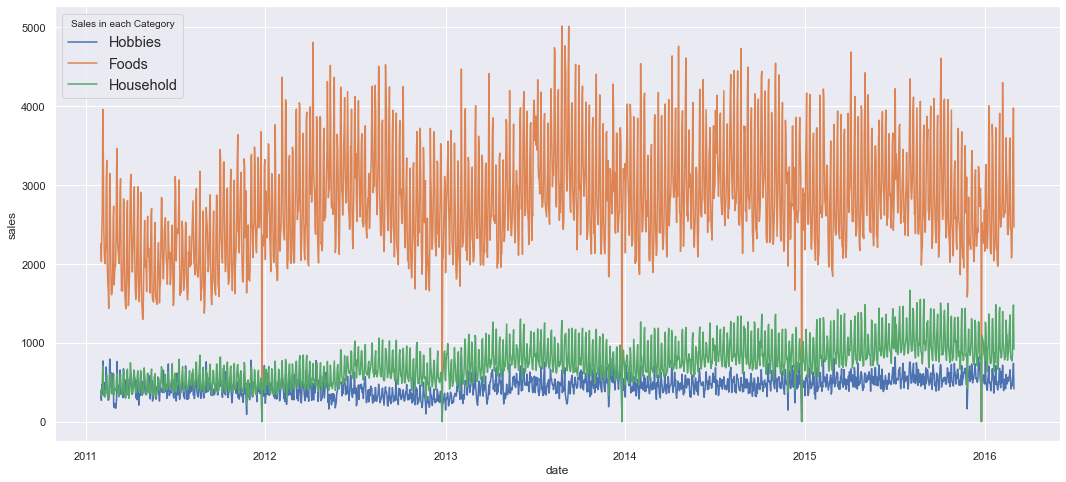

In [40]:
# Sales pro Kategorie
sns.lineplot(x = 'date', y = 'sales', data =  hobbies_grouped)
sns.lineplot(x = 'date', y = 'sales', data =  food_grouped)
sns.lineplot(x = 'date', y = 'sales', data =  household_grouped)
plt.legend(labels=['Hobbies','Foods','Household'], title = "Sales in each Category", 
           fontsize = 'large', title_fontsize = "10")

In [ ]:
# Allgemeine Daten Exploration des Sales-Datensatzes

print('Unique Item IDs: ')
display(sales_data['item_id'].unique())
print('#####')
print('Unique Department IDs: ')
display(sales_data['dept_id'].unique())
print('#####')
print('Unique Category IDs: ')
display(sales_data['cat_id'].unique())
print('#############################################')
number_of_unique_items = len(set(sales_data['item_id']))
print('#### Number of unique items: ' + str(number_of_unique_items)+ ' ###########')
number_of_unique_categories = len(set(sales_data['cat_id']))
print('#### Number of unique categories: ' + str(number_of_unique_categories) + ' #########')
print('#############################################')

In [ ]:
# Allgemeine Daten Exploration des Calendar-Datensatzes

print('Unique Event Names "1" : ')
display(calendar_data['event_name_1'].unique())
print('#####')
print('Unique Event Types "1" : ')
display(calendar_data['event_type_1'].unique())
print('#####')
print('Unique Event Names "2" : ')
display(calendar_data['event_name_2'].unique())
print('#####')
print('Unique Event Types "2" : ')
display(calendar_data['event_type_2'].unique())
print('#############################################')
number_of_unique_event_name_1 = len(set(calendar_data['event_name_1']))
print('Number of unique event names 1: ' + str(number_of_unique_event_name_1)+ ' ##########')
number_of_unique_event_type_1 = len(set(calendar_data['event_type_1']))
print('Number of unique event types 1: ' + str(number_of_unique_event_type_1)+ ' ###########')
number_of_unique_event_name_2 = len(set(calendar_data['event_name_2']))
print('Number of unique event names 2: ' + str(number_of_unique_event_name_2)+ ' ###########')
number_of_unique_event_type_2 = len(set(calendar_data['event_type_2']))
print('Number of unique event types 2: ' + str(number_of_unique_event_type_2)+ ' ###########')
print('#############################################')

In [ ]:
# Allgemeine Daten Exploration des Calendar-Datensatzes

print('Unique Item IDs : ')
display(prices_data['item_id'].unique())
print('#############################################')
number_of_unique_items = len(set(prices_data['item_id']))
print('Number of unique items: ' + str(number_of_unique_items)+ ' ################')
number_of_unique_week_id = len(set(prices_data['week_id']))
print('Number of unique week ids: ' + str(number_of_unique_week_id)+ ' ##############')
print('#############################################')

In [42]:
# Datensatz full_data_clean für Boxplots aufbereiten
full_data_clean = full_data_clean.replace(np.nan, 'no event', regex=True)

 

full_data_clean['event_type_1'] = pd.np.where(full_data_clean.event_type_1.str.contains("National"), "National", 
                                              pd.np.where(full_data_clean.event_type_1.str.contains("Religious"), "Religious",
                                                          pd.np.where(full_data_clean.event_type_1.str.contains("Cultural"), "Cultural",
                                                                      pd.np.where(full_data_clean.event_type_1.str.contains("Sporting"), "Sporting", 'no event'))))
                                              
                                              
full_data_clean['event_type_2'] = pd.np.where(full_data_clean.event_type_2.str.contains("Religious"), "Religious",
                                                          pd.np.where(full_data_clean.event_type_2.str.contains("Cultural"), "Cultural",
                                                                      'no event'))   

full_data_agg = full_data_clean.groupby('date').apply(
        lambda full_data_clean: pd.Series({
            'sales': full_data_clean.sales.sum(),
            'month': full_data_clean.Month.value_counts().index[0],
            'weekday': full_data_clean.Weekday.value_counts().index[0],
            'event_name_1': full_data_clean.event_name_1.value_counts().index[0],
            'event_type_1': full_data_clean.event_type_1.value_counts().index[0],
            'event_name_2': full_data_clean.event_name_2.value_counts().index[0],
            'event_type_2': full_data_clean.event_type_2.value_counts().index[0]
            }))

<ipython-input-42-934cb80f472e>:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  full_data_clean['event_type_1'] = pd.np.where(full_data_clean.event_type_1.str.contains("National"), "National",
<ipython-input-42-934cb80f472e>:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.where(full_data_clean.event_type_1.str.contains("Religious"), "Religious",
<ipython-input-42-934cb80f472e>:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.where(full_data_clean.event_type_1.str.contains("Cultural"), "Cultural",
<ipython-input-42-934cb80f472e>:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.where(full_data_clean.event_type_1.str.co

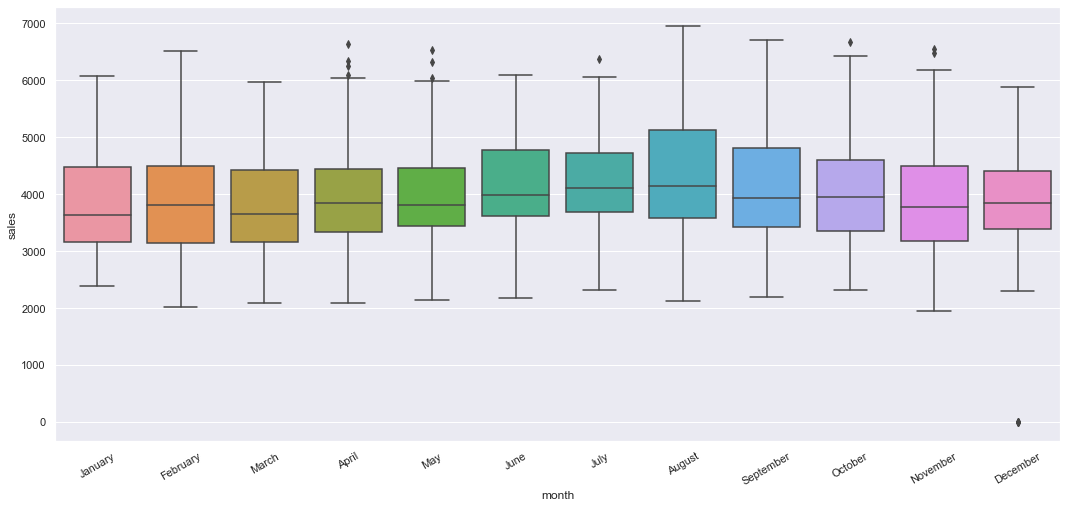

In [43]:
# Boxplot der Sales pro Monat
month_boxplot = sns.boxplot(x = 'month', y = "sales", data = full_data_agg, order = ['January', 'February', 'March','April','May','June','July', 'August','September','October','November','December'])
month_boxplot.set_xticklabels(month_boxplot.get_xticklabels(),rotation=30)
plt.show()

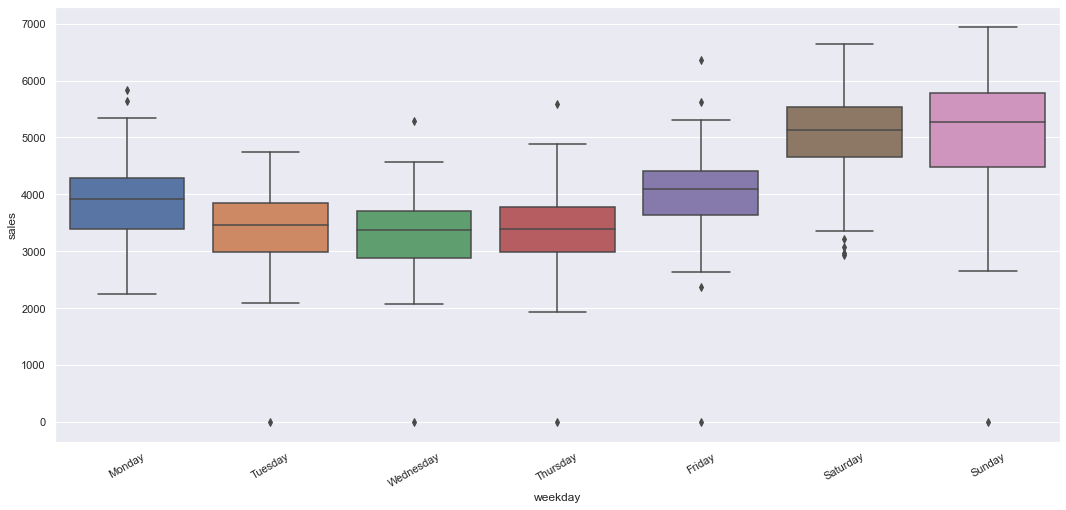

In [44]:
# Boxplot für Sales pro Wochentag
weekday_boxplot = sns.boxplot(x = 'weekday', y = "sales", data = full_data_agg, order = ['Monday', 'Tuesday', 'Wednesday','Thursday','Friday','Saturday','Sunday'])
weekday_boxplot.set_xticklabels(weekday_boxplot.get_xticklabels(),rotation=30)
plt.show()

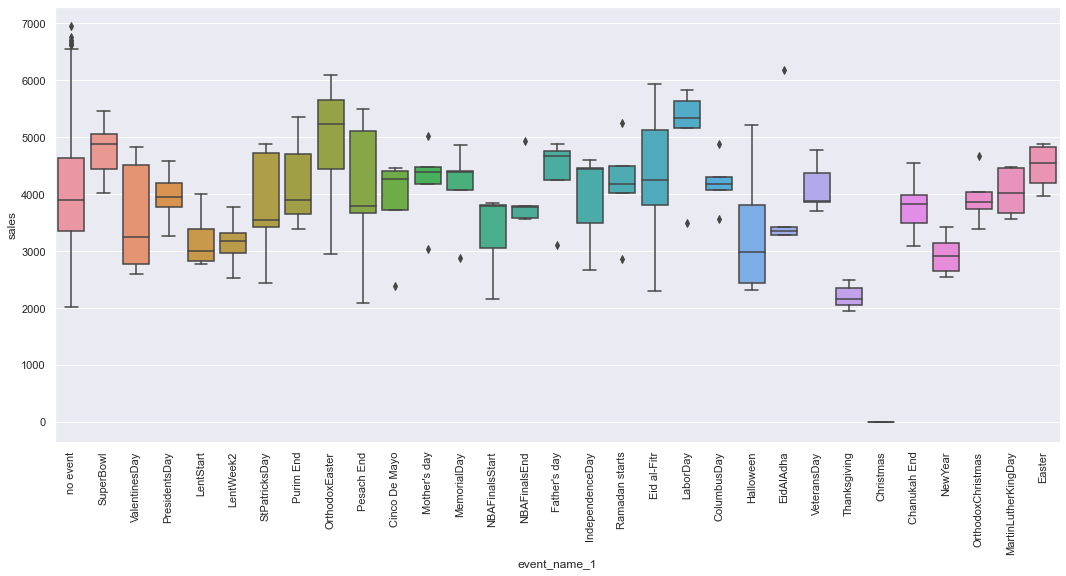

In [45]:
# Boxplot für Sales pro Event nach Name (1)
event_name_1_boxplot = sns.boxplot(x = 'event_name_1', y = "sales", data = full_data_agg)
event_name_1_boxplot.set_xticklabels(event_name_1_boxplot.get_xticklabels(),rotation=90)
plt.show()

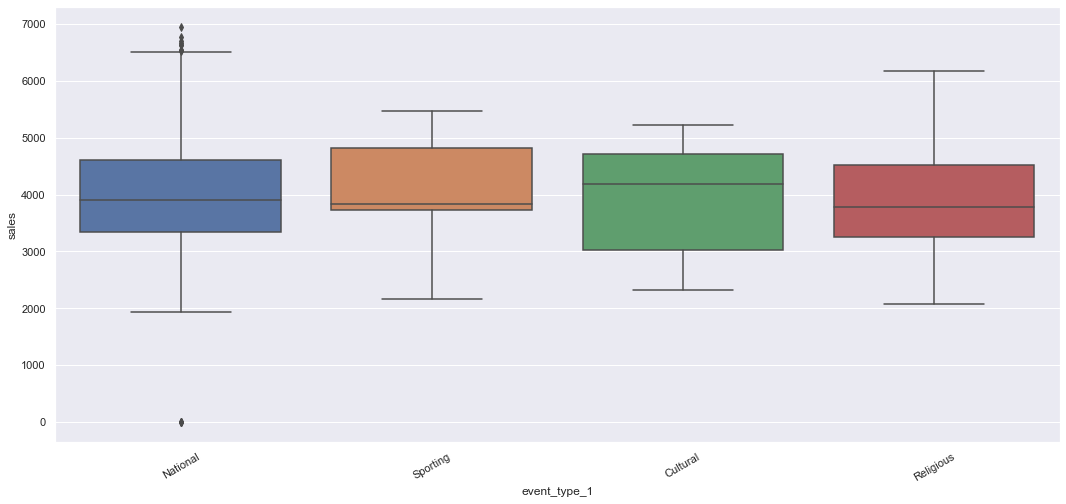

In [46]:
# Boxplot für Sales pro Event nach Typ (1)
event_type_1_boxplot = sns.boxplot(x = 'event_type_1', y = "sales", data = full_data_agg)
event_type_1_boxplot.set_xticklabels(event_type_1_boxplot.get_xticklabels(),rotation=30)
plt.show()

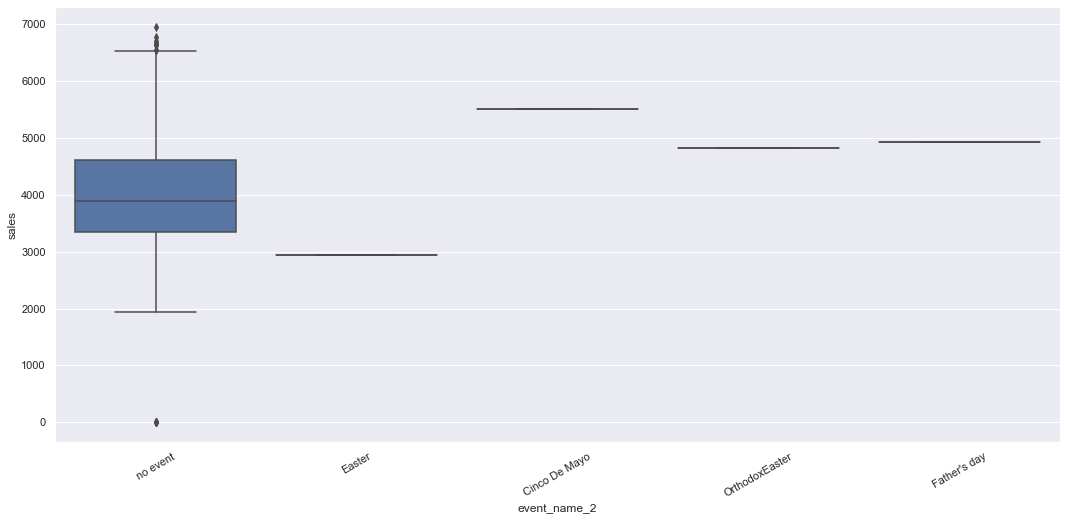

In [47]:
# Boxplot für Sales pro Event nach Name (2)
event_name_2_boxplot = sns.boxplot(x = 'event_name_2', y = "sales", data = full_data_agg)
event_name_2_boxplot.set_xticklabels(event_name_2_boxplot.get_xticklabels(),rotation=30)
plt.show()

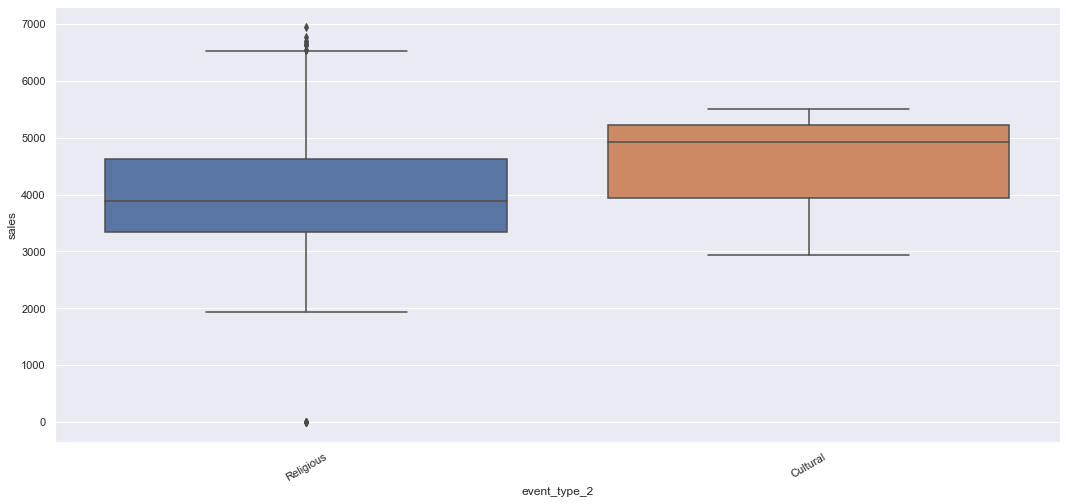

In [48]:
# Boxplot für Sales pro Event nach Typ (2)
event_type_2_boxplot = sns.boxplot(x = 'event_type_2', y = "sales", data = full_data_agg)
event_type_2_boxplot.set_xticklabels(event_type_2_boxplot.get_xticklabels(),rotation=30)
plt.show()

## 3. Modeling

### 3.1 Feature importance

In [ ]:
#Definition der verwendeten Trainings- und Testdatensätze

# Variablen in zwei Datensätze splitten -> x = Erklärende Variablen; y = Sales
x_food = food_grouped.drop(columns = ['sales'])
y_food = food_grouped[['sales']]

x_hobbies = hobbies_grouped.drop(columns = ['sales'])
y_hobbies = hobbies_grouped[['sales']]

x_household = household_grouped.drop(columns = ['sales'])
y_household = household_grouped[['sales']]

train_food, test_food           = temporal_train_test_split(food_grouped, test_size = 30)
train_hobbies, test_hobbies     = temporal_train_test_split(hobbies_grouped, test_size = 30)
train_household, test_household = temporal_train_test_split(household_grouped, test_size = 30)

In [ ]:
# Food

k = np.floor(len(food_grouped)/30).astype(int)
cv = KFold(n_splits = k)
forecast = RandomForestRegressor(max_depth = 7)
scores = pd.DataFrame(cross_validate
                      (
                          forecast,
                          x_food,
                          y_food.values.ravel(),
                          scoring = 'neg_mean_absolute_error',
                          cv = cv,
                          verbose =1)
                     )

print('MAE mean:\t %4.2f' % (-scores['test_score'].mean()))
print('MAE mad:\t %4.2f' % (scores['test_score'].mad()))

In [ ]:
forecast.fit(x_food, y_food.values.ravel())
importance = pd.DataFrame(data = forecast.feature_importances_, index = x_food.columns)
importance.columns = ['Importance']
display(importance.sort_values(by='Importance', ascending = False))
display(x_food.shape)

In [ ]:
# Automatisierte Merkmalsauswahl

k = np.floor(len(food_grouped)/30).astype(int)
cv = KFold(n_splits = k)

forecast = RandomForestRegressor(max_depth = 7)

selector = RFECV(
    forecast,
    step = 1,
    cv = cv,
    scoring = 'neg_mean_absolute_error'
)

selector = selector.fit(x_food, y_food.values.ravel())

selection = pd.DataFrame(data = selector.support_, index = x_food.columns)
selection.columns = ['Selected']
selection.index.name = 'Variable'
display(selection)

scores = pd.DataFrame(
    cross_validate(
        forecast,
        selector.transform(x_food),
        y_food.values.ravel(),
        scoring = 'neg_mean_absolute_error',
        cv = cv,
        verbose = 1
    )
)

print('MAE mean:\t %4.2f' % (-scores['test_score'].mean()))
print('MAE mad:\t %4.2f' % (scores['test_score'].mad()))

In [ ]:
# Hobbies
k = np.floor(len(hobbies_grouped)/30).astype(int)
cv = KFold(n_splits = k)

forecast = RandomForestRegressor(max_depth = 7)
scores = pd.DataFrame(cross_validate
                      (
                          forecast,
                          x_hobbies,
                          y_hobbies.values.ravel(),
                          scoring = 'neg_mean_absolute_error',
                          cv = cv,
                          verbose =1)
                     )

print('MAE mean:\t %4.2f' % (-scores['test_score'].mean()))
print('MAE mad:\t %4.2f' % (scores['test_score'].mad()))

In [ ]:
forecast.fit(x_hobbies, y_hobbies.values.ravel())
importance = pd.DataFrame(data = forecast.feature_importances_, index = x_hobbies.columns)
importance.columns = ['Importance']
display(importance.sort_values(by='Importance', ascending = False))
display(x_hobbies.shape)

In [ ]:
# Automatisierte Merkmalsauswahl

k = np.floor(len(hobbies_grouped)/30).astype(int)
cv = KFold(n_splits = k)

forecast = RandomForestRegressor(max_depth = 7)

selector = RFECV(
    forecast,
    step = 1,
    cv = cv,
    scoring = 'neg_mean_absolute_error'
)

selector = selector.fit(x_hobbies, y_hobbies.values.ravel())

selection = pd.DataFrame(data = selector.support_, index = x_hobbies.columns)
selection.columns = ['Selected']
selection.index.name = 'Variable'
display(selection)

scores = pd.DataFrame(
    cross_validate(
        forecast,
        selector.transform(x_hobbies),
        y_hobbies.values.ravel(),
        scoring = 'neg_mean_absolute_error',
        cv = cv,
        verbose = 1
    )
)

print('MAE mean:\t %4.2f' % (-scores['test_score'].mean()))
print('MAE mad:\t %4.2f' % (scores['test_score'].mad()))

In [ ]:
# Household
k = np.floor(len(household_grouped)/30).astype(int)
cv = KFold(n_splits = k)

forecast = RandomForestRegressor(max_depth = 7)

scores = pd.DataFrame(cross_validate
                      (
                          forecast,
                          x_household,
                          y_household.values.ravel(),
                          scoring = 'neg_mean_absolute_error',
                          cv = cv,
                          verbose =1)
                     )

print('MAE mean:\t %4.2f' % (-scores['test_score'].mean()))
print('MAE mad:\t %4.2f' % (scores['test_score'].mad()))

In [ ]:
forecast.fit(x_household, y_household.values.ravel())
importance = pd.DataFrame(data = forecast.feature_importances_, index = x_household.columns)
importance.columns = ['Importance']
display(importance.sort_values(by='Importance', ascending = False))
display(x_household.shape)

In [ ]:
# Automatisierte Merkmalsauswahl

k = np.floor(len(household_grouped)/30).astype(int)
cv = KFold(n_splits = k)

forecast = RandomForestRegressor(max_depth = 7)

selector = RFECV(
    forecast,
    step = 1,
    cv = cv,
    scoring = 'neg_mean_absolute_error'
)

selector = selector.fit(x_household, y_household.values.ravel())

selection = pd.DataFrame(data = selector.support_, index = x_household.columns)
selection.columns = ['Selected']
selection.index.name = 'Variable'
display(selection)

scores = pd.DataFrame(
    cross_validate(
        forecast,
        selector.transform(x_household),
        y_household.values.ravel(),
        scoring = 'neg_mean_absolute_error',
        cv = cv,
        verbose = 1
    )
)

print('MAE mean:\t %4.2f' % (-scores['test_score'].mean()))
print('MAE mad:\t %4.2f' % (scores['test_score'].mad()))

### 3.2 Einfache Verfahren

Bei den einfachen Verfahren werden alle Strategien getestet. Auf der besten Strategie wird dan jeweils evaluiert. Als Benchmark wird dann die Strategie genommen, welche den besten RMSE vorweist.

In [ ]:
#Einfache Verfahren Kategorie Food
train_food.index.freq = 'D'
test_food.index.freq = 'D'

fh_food = ForecastingHorizon(test_food.index, is_relative = False)

for strategy in ['mean', 'last', 'drift']:
    if strategy == 'drift':
        forecast = NaiveForecaster(strategy = strategy)
    else:
        forecast = NaiveForecaster(strategy = strategy, sp = 7)
    forecast.fit(train_food['sales'])
    
    sns.lineplot(data = train_food['sales'], label = 'Train')
    sns.scatterplot(data = test_food['sales'], color = 'black', label = 'Test')
    sns.lineplot(data = forecast.predict(fh_food), label = 'Prediction')
    plt.title(strategy)
    plt.show()
    
    sns.scatterplot(data = test_food['sales'], color = 'black', label = 'Test')
    sns.lineplot(data = forecast.predict(fh_food), color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
    plt.title(strategy)
    plt.show()

    print('MAE:\t %4.2f' % (MAE(y_true = test_food['sales'], y_pred = forecast.predict(fh_food))))
    naive_food_mse = MSE(y_true = test_food['sales'], y_pred = forecast.predict(fh_food))
    naive_food_rmse= sqrt(naive_food_mse)
    print('RMSE:\t %4.2f' % naive_food_rmse)

In [ ]:
#Evaluation einfache Verfahren Kategorie Food, beste strategy = last

mse = MeanSquaredError()

food_grouped.index.freq = 'D'

cv = ExpandingWindowSplitter(
    fh = 30,
    initial_window = len(train_food)-12*30,
    step_length=30
)

forecast = NaiveForecaster(strategy="last", sp=7)

scores = evaluate(
    forecaster = forecast,
    cv = cv,
    y = train_food['sales'],
    strategy = 'refit',
    scoring = mse
)

display(scores)

print('MSE mean:\t %4.2f' % (scores['test_MeanSquaredError'].mean()))
naive_food_cv= sqrt((scores['test_MeanSquaredError'].mean()))
print('RMSE mean:\t %4.2f' % naive_food_cv)

In [ ]:
#Einfache Verfahren Kategorie Hobbies 
train_hobbies.index.freq = 'D'
test_hobbies.index.freq = 'D'

fh_hobbies = ForecastingHorizon(test_hobbies.index, is_relative = False)

for strategy in ['mean', 'last', 'drift']:
    if strategy == 'drift':
        forecast = NaiveForecaster(strategy = strategy)
    else:
        forecast = NaiveForecaster(strategy = strategy, sp = 7)
    forecast.fit(train_hobbies['sales'])
    
    sns.lineplot(data = train_hobbies['sales'], label = 'Train')
    sns.scatterplot(data = test_hobbies['sales'], color = 'black', label = 'Test')
    sns.lineplot(data = forecast.predict(fh_hobbies), label = 'Prediction')
    plt.title(strategy)
    plt.show()
    
    sns.scatterplot(data = test_hobbies['sales'], color = 'black', label = 'Test')
    sns.lineplot(data = forecast.predict(fh_hobbies), color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
    plt.title(strategy)
    plt.show()

    print('MAE:\t %4.2f' % (MAE(y_true = test_hobbies['sales'], y_pred = forecast.predict(fh_hobbies))))
    naive_hobbies_mse = MSE(y_true = test_food['sales'], y_pred = forecast.predict(fh_hobbies))
    naive_hobbies_rmse= sqrt(naive_hobbies_mse)
    print('RMSE:\t %4.2f' % naive_hobbies_rmse)

In [ ]:
#Evaluation einfache Verfahren  Kategorie Hobbies, beste strategy = last
hobbies_grouped.index.freq = 'D'

cv = ExpandingWindowSplitter(
    fh = 30,
    initial_window = len(hobbies_grouped)-12*30,
    step_length=30
)

forecast = NaiveForecaster(strategy="last", sp=7)

scores = evaluate(
    forecaster = forecast,
    cv = cv,
    y = train_hobbies['sales'],
    strategy = 'refit',
    scoring = mse
)

display(scores)

print('MSE mean:\t %4.2f' % (scores['test_MeanSquaredError'].mean()))
naive_hobbies_cv= sqrt((scores['test_MeanSquaredError'].mean()))
print('RMSE mean:\t %4.2f' % naive_hobbies_cv)

In [ ]:
#Einfache Verfahren Kategorie Household
train_household.index.freq = 'D'
test_household.index.freq = 'D'

fh_household = ForecastingHorizon(test_household.index, is_relative = False)

for strategy in ['mean', 'last', 'drift']:
    if strategy == 'drift':
        forecast = NaiveForecaster(strategy = strategy)
    else:
        forecast = NaiveForecaster(strategy = strategy, sp = 7)
    forecast.fit(train_household['sales'])
    
    sns.lineplot(data = train_household['sales'], label = 'Train')
    sns.scatterplot(data = test_household['sales'], color = 'black', label = 'Test')
    sns.lineplot(data = forecast.predict(fh_household), label = 'Prediction')
    plt.title(strategy)
    plt.show()
    
    sns.scatterplot(data = test_household['sales'], color = 'black', label = 'Test')
    sns.lineplot(data = forecast.predict(fh_household), color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
    plt.title(strategy)
    plt.show()

    print('MAE:\t %4.2f' % (MAE(y_true = test_household['sales'], y_pred = forecast.predict(fh_household))))
    naive_household_mse = MSE(y_true = test_household['sales'], y_pred = forecast.predict(fh_household))
    naive_household_rmse= sqrt(naive_household_mse)
    print('RMSE:\t %4.2f' % naive_household_rmse)

In [ ]:
#Evaluation einfache Verfahren Kategorie Household, beste strategy = last
household_grouped.index.freq = 'D'

cv = ExpandingWindowSplitter(
    fh = 30,
    initial_window = len(household_grouped)-12*30,
    step_length=30
)

forecast = NaiveForecaster(strategy="last", sp=7)

scores = evaluate(
    forecaster = forecast,
    cv = cv,
    y = train_household['sales'],
    strategy = 'refit',
    scoring = mse
)

display(scores)

print('MSE mean:\t %4.2f' % (scores['test_MeanSquaredError'].mean()))
naive_household_cv= sqrt((scores['test_MeanSquaredError'].mean()))
print('RMSE mean:\t %4.2f' % naive_household_cv)

Anhand der vorausgegangenen Forecasts und des RMSE-Vergleichs wurde die Strategie "Last" bei allen Kategorien als beste Strategie identifiziert und entsprechend auch auf dieser Strategie evaluiert. Im Folgenden werden die Forecast-Daten dieser Strategie für alle Kategorien in seperate Tabellen geschrieben, um im Anschluss die Aggregation über alle Kategorien durchzuführen. 

In [ ]:
#Einfache Verfahren beste Strategie Sales-Forecasts in Tabellen schreiben 

#Forecast Food
train_food.index.freq = 'D'
test_food.index.freq = 'D'
fh_food_last = ForecastingHorizon(test_food.index, is_relative = False)

forecast = NaiveForecaster(strategy = 'last', sp=7)
forecast.fit(train_food['sales'])

prediction_food = pd.DataFrame(data = forecast.predict(fh_food_last), index = pd.date_range(start = test_food.index.min(), end = test_food.index.max()))
prediction_food.index.name = 'date'
prediction_food.columns = ['sales']
prediction_food[prediction_food.sales < 0] = 0
display(prediction_food.head())

#Forecast Hobbies 
train_hobbies, test_hobbies = temporal_train_test_split(hobbies_grouped, test_size = 30)

train_hobbies.index.freq = 'D'
test_hobbies.index.freq = 'D'
fh_hobbies_last = ForecastingHorizon(test_hobbies.index, is_relative = False)

forecast = NaiveForecaster(strategy = 'last', sp=7)
forecast.fit(train_hobbies['sales'])

prediction_hobbies = pd.DataFrame(data = forecast.predict(fh_hobbies_last), index = pd.date_range(start = test_hobbies.index.min(), end = test_hobbies.index.max()))
prediction_hobbies.index.name = 'date'
prediction_hobbies.columns = ['sales']
prediction_hobbies[prediction_hobbies.sales < 0] = 0
display(prediction_hobbies.head())

#Forecast Household
train_household, test_household = temporal_train_test_split(household_grouped, test_size = 30)

train_household.index.freq = 'D'
test_household.index.freq = 'D'
fh_household_last = ForecastingHorizon(test_household.index, is_relative = False)

forecast = NaiveForecaster(strategy = 'last', sp=7)
forecast.fit(train_household['sales'])

prediction_household = pd.DataFrame(data = forecast.predict(fh_household_last), index = pd.date_range(start = test_household.index.min(), end = test_household.index.max()))
prediction_household.index.name = 'date'
prediction_household.columns = ['sales']
prediction_household[prediction_household.sales < 0] = 0
display(prediction_household.head())

In [ ]:
#Aggregation der Test- und Trainingsdaten aller Kategorien bestes einfaches Verfahren
# Trainingdaten
naive_train_agg = pd.merge(train_food['sales'], train_hobbies['sales'], on= "date")
naive_train_agg = pd.merge(naive_train_agg, train_household['sales'], on='date')
naive_train_agg['Total'] = naive_train_agg.sum(axis=1)
naive_train_agg = naive_train_agg.rename(columns={"sales_x":"sales_food","sales_y":"sales_hobbies","sales":"sales_household"})
naive_train_agg = pd.DataFrame(naive_train_agg)
naive_train_agg.sort_values(by='date', inplace=True, ignore_index=False)
display(naive_train_agg.head())

# Testdaten
naive_test_agg = pd.merge(prediction_food['sales'], prediction_hobbies['sales'], on= "date")
naive_test_agg = pd.merge(naive_test_agg, prediction_household['sales'], on='date')
naive_test_agg['Total'] = naive_test_agg.sum(axis=1)
naive_test_agg = naive_test_agg.rename(columns={"sales_x":"sales_food","sales_y":"sales_hobbies","sales":"sales_household"})
naive_test_agg = pd.DataFrame(naive_test_agg)
naive_test_agg.sort_values(by='date', inplace=True, ignore_index=False)
display(naive_test_agg.head())

#Trainings- und Testdaten untereinander mergen
naive_total_agg = naive_train_agg.append(naive_test_agg)
display(naive_total_agg)

# Visualisierung
data_february = data_grouped.loc['2016-02-01':'2016-02-29']

#display(data_february)
sns.lineplot(data = naive_train_agg['Total'], label = 'Train')
sns.scatterplot(data = data_february['sales'], color = 'black', label = 'Test')
sns.lineplot(data = naive_test_agg['Total'], label = 'Prediction')
plt.title('einfache Verfahren Gesamtsales')
plt.show()

sns.scatterplot(data = data_february['sales'], color = 'black', label = 'Test')
sns.lineplot(data = naive_test_agg['Total'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('einfache Verfahren Gesamtsales')
plt.show()

#Berechnung Gesamt-RMSE
rmse_naive_ges = ((naive_food_cv+naive_hobbies_cv+naive_household_cv)/3)
print('RMSE_Naive_Gesamt:\t %4.2f' % rmse_naive_ges)

Ingesamt schneidet das beste Modell bei den einfachen Verfahren mit einem durchschnittlichen RMSE über alle Kategorien von 514.64 ab.

### 3.3 Exponentielle Glättung

In [ ]:
# Exponentielle Glättung auf Food-Datensatz [TEIL1]
# Food-Datensatz splitten

train_food.index.freq = 'D'
test_food.index.freq = 'D'
fh_food = ForecastingHorizon(test_food.index, is_relative = False)

# Modell trainieren
forecast = ExponentialSmoothing(trend='add', seasonal='add', sp=7)
forecast.fit(train_food['sales'])
sns.lineplot(data = train_food['sales'], label = 'Train')
sns.scatterplot(data = test_food['sales'], color = 'black', label = 'Test')

# Vorhersagen
sns.lineplot(data = forecast.predict(fh_food), label = 'Prediction')
plt.title(strategy)
plt.show()

# Visualisierung der Vorhersage
sns.scatterplot(data = test_food['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast.predict(fh_food), color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title(strategy)
plt.show()

expo_food_mse = MSE(y_true = test_food['sales'], y_pred = forecast.predict(fh_food))
expo_food_rmse= sqrt(expo_food_mse)
print('RMSE:\t %4.2f' % expo_food_rmse)

In [ ]:
# Evaluation der Exponentiellen Glättung auf Food-Datensatz via Expanding Window Splitting 

food_grouped.index.freq = 'D'

# Kreuzvalidierung
cv = ExpandingWindowSplitter(
    fh = 30,
    initial_window = len(food_grouped)-12*30,
    step_length=30
)

# Ermittlung des Mean Squared Error (MSE) zwecks Kalkulation des RMSE  
MSE = MeanSquaredError()
ets = ExponentialSmoothing(
    damped_trend = True,
    seasonal = 'add',
    sp = 7,
    trend = 'add'
)

scores = evaluate(
    forecaster = ets,
    cv = cv,
    y = train_food['sales'],
    strategy = 'refit',
    scoring = MSE
)
display(scores)

# Kalkulation des Root Mean Squared Error (RMSE) als Evaluationskriterium
RMSE_expo_smoothing_food = sqrt((scores['test_MeanSquaredError'].mean()))

print('RMSE:\t %4.2f' % RMSE_expo_smoothing_food)

In [ ]:
train_hobbies.index.freq = 'D'
test_hobbies.index.freq = 'D'
fh_hobbies = ForecastingHorizon(test_hobbies.index, is_relative = False)

# Modell trainieren
forecast = ExponentialSmoothing(trend='add', seasonal='add', sp=7)
forecast.fit(train_hobbies['sales'])
sns.lineplot(data = train_hobbies['sales'], label = 'Train')
sns.scatterplot(data = test_hobbies['sales'], color = 'black', label = 'Test')

# Vorhersagen
sns.lineplot(data = forecast.predict(fh_hobbies), label = 'Prediction')
plt.title('Exp. Smoothing Hobbies')
plt.show()

# Visualisierung der Vorhersage
sns.scatterplot(data = test_hobbies['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast.predict(fh_hobbies), color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Exp. Smoothing Hobbies')
plt.show()

In [ ]:
# Evaluation der Exponentiellen Glättung auf Hobbies-Datensatz via Expanding Window Splitting 
hobbies_grouped.index.freq = 'D'
# Kreuzvalidierung
cv = ExpandingWindowSplitter(
    fh = 30,
    initial_window = len(hobbies_grouped)-12*30,
    step_length=30
)

# Ermittlung des Mean Squared Error (MSE) zwecks Kalkulation des RMSE  
MSE = MeanSquaredError()
ets = ExponentialSmoothing(
    damped_trend = True,
    seasonal = 'add',
    sp =7,
    trend = 'add'
)

scores = evaluate(
    forecaster = ets,
    cv = cv,
    y = train_hobbies['sales'],
    strategy = 'refit',
    scoring = MSE
)

display(scores)

# Kalkulation des Root Mean Squared Error (RMSE) als Evaluationskriterium
RMSE_expo_smoothing_hobbies = sqrt((scores['test_MeanSquaredError'].mean()))

print('RMSE:\t %4.2f' % RMSE_expo_smoothing_hobbies)

In [ ]:
# Exponentielle Glättung auf Household-Datensatz [TEIL3]

train_household.index.freq = 'D'
test_household.index.freq = 'D'
fh_household = ForecastingHorizon(test_household.index, is_relative = False)

# Modell trainieren
forecast = ExponentialSmoothing(trend='add', seasonal='add', sp=7)
forecast.fit(train_household['sales'])
sns.lineplot(data = train_household['sales'], label = 'Train')
sns.scatterplot(data = test_household['sales'], color = 'black', label = 'Test')

# Vorhersagen
sns.lineplot(data = forecast.predict(fh_household), label = 'Prediction')
plt.title('Exp. Smoothing Household')
plt.show()

# Visualisierung der Vorhersage
sns.scatterplot(data = test_household['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast.predict(fh_household), color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Exp. Smoothing Household')
plt.show()

In [ ]:
# Evaluation der Exponentiellen Glättung auf Household-Datensatz via Expanding Window Splitting 

household_grouped.index.freq = 'D'

#from sktime.performance_metrics.forecasting import MeanSquaredError

# Kreuzvalidierung
cv = ExpandingWindowSplitter(
    fh = 30,
    initial_window = len(household_grouped)-12*30,
    step_length=30
)


# Ermittlung des Mean Squared Error (MSE) zwecks Kalkulation des RMSE  
MSE = MeanSquaredError()
ets = ExponentialSmoothing(
    damped_trend = True,
    seasonal = 'add',
    sp = 7,
    trend = 'add'
)

scores = evaluate(
    forecaster = ets,
    cv = cv,
    y = train_household['sales'],
    strategy = 'refit',
    scoring = MSE
)

display(scores)

# Kalkulation des Root Mean Squared Error (RMSE) als Evaluationskriterium
RMSE_expo_smoothing_household = sqrt((scores['test_MeanSquaredError'].mean()))

print('RMSE:\t %4.2f' % RMSE_expo_smoothing_household)

In [ ]:
#Prognostizierte Werte pro Food-Kategorie in Tabelle schreiben
prediction_food = pd.DataFrame(data = forecast.predict(fh_food), index = pd.date_range(start = test_food.index.min(), end = test_food.index.max()))
prediction_food.index.name = 'date'
prediction_food.columns = ['sales']
prediction_food[prediction_food.sales < 0] = 0
display(prediction_food.head())

#Prognostizierte Werte pro Household-Kategorie in Tabelle schreiben
prediction_household = pd.DataFrame(data = forecast.predict(fh_household), index = pd.date_range(start = test_household.index.min(), end = test_household.index.max()))
prediction_household.index.name = 'date'
prediction_household.columns = ['sales']
prediction_household[prediction_household.sales < 0] = 0
display(prediction_household.head())

# Prognostizierte Werte pro Hobbies-Kategorie in Tabelle schreiben
prediction_hobbies = pd.DataFrame(data = forecast.predict(fh_hobbies), index = pd.date_range(start = test_hobbies.index.min(), end = test_hobbies.index.max()))
prediction_hobbies.index.name = 'date'
prediction_hobbies.columns = ['sales']
prediction_hobbies[prediction_hobbies.sales < 0] = 0
display(prediction_hobbies.head())

In [ ]:
#Aggregation aller Modelle Exp. Smoothing
# Trainingdaten
expo_smoothing_train_agg = pd.merge(train_food['sales'], train_hobbies['sales'], on= "date")
expo_smoothing_train_agg = pd.merge(expo_smoothing_train_agg, train_household['sales'], on='date')
expo_smoothing_train_agg['Total'] = expo_smoothing_train_agg.sum(axis=1)
expo_smoothing_train_agg = expo_smoothing_train_agg.rename(columns={"sales_x":"sales_food","sales_y":"sales_hobbies","sales":"sales_household"})
expo_smoothing_train_agg = pd.DataFrame(expo_smoothing_train_agg)
expo_smoothing_train_agg.sort_values(by='date', inplace=True, ignore_index=False)
display(expo_smoothing_train_agg.head())

# Testdaten
expo_smoothing_test_agg = pd.merge(forecast.predict(fh_food), forecast.predict(fh_hobbies), on= "date") 
expo_smoothing_test_agg = pd.merge(expo_smoothing_test_agg, forecast.predict(fh_household), on='date')
expo_smoothing_test_agg['Total'] = expo_smoothing_test_agg.sum(axis=1)
expo_smoothing_test_agg = expo_smoothing_test_agg.rename(columns={"sales_x":"sales_food","sales_y":"sales_hobbies","sales":"sales_household"})
expo_smoothing_test_agg = pd.DataFrame(expo_smoothing_test_agg)
expo_smoothing_test_agg.sort_values(by='date', inplace=True, ignore_index=False)
display(expo_smoothing_test_agg.head())

#Trainings- und Testdaten zusammenfügen
expo_smoothing_total_agg = expo_smoothing_train_agg.append(expo_smoothing_test_agg)
display(expo_smoothing_total_agg)

# Visualisierung
data_february = data_grouped.loc['2016-02-01':'2016-02-29']
#display(data_february)

sns.lineplot(data = expo_smoothing_train_agg['Total'], label = 'Train')
sns.scatterplot(data = data_february['sales'], color = 'black', label = 'Test')
sns.lineplot(data = expo_smoothing_test_agg['Total'], label = 'Prediction')
plt.title('Expo Smoothing Gesamtsales')
plt.show()

sns.scatterplot(data = data_february['sales'], color = 'black', label = 'Test')
sns.lineplot(data = expo_smoothing_test_agg['Total'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Expo Smoothing Gesamtsales')
plt.show()

RMSE_Expo_Smoothing_Gesamt=((RMSE_expo_smoothing_food+RMSE_expo_smoothing_hobbies+RMSE_expo_smoothing_household)/3)
print('RMSE_Expo_Smoothing_Gesamt:\t %4.2f' % RMSE_Expo_Smoothing_Gesamt)

In [ ]:
RMSE_Expo_Smoothing_Gesamt=((RMSE_expo_smoothing_food+RMSE_expo_smoothing_hobbies+RMSE_expo_smoothing_household)/3)
print('RMSE_Expo_Smoothing_Gesamt:\t %4.2f' % RMSE_Expo_Smoothing_Gesamt)

### 3.4 Lineare Regression

Als nächstes Modell wurde die lineare Regression ausgewählt. Um den Rechenaufwand zu verringern und die Prognosegenauigkeit zu erhöhen, wurde der Datensatz auf die durch die automatisierte Merkmalsauwahl festgelegten Features begrenzt und das Modell mit den verbliebenen Variablen gefittet.


In [ ]:
#Datensatz begrenzen
food1_grouped = food_grouped.drop(["Month_March","event_type_1_Religious", "event_type_1_Sporting","event_type_2_Cultural","event_type_2_Religious"],axis = 1)


In [ ]:
#Modellierung Food

train_food, test_food = temporal_train_test_split(food1_grouped, test_size = 30)

train_food.index.freq = 'D'
test_food.index.freq = 'D'
fh = ForecastingHorizon(test_food.index, is_relative = False)

reg = LinearRegression()
forecast = make_reduction(reg, window_length = 30, strategy = "recursive")

forecast.fit(train_food['sales'])
   
sns.lineplot(data = train_food['sales'], label = 'Train')
sns.scatterplot(data = test_food['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast.predict(fh), label = 'Prediction')
plt.title('Linear Regression')
plt.show()

sns.scatterplot(data = test_food['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast.predict(fh), color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Linear Regression')
plt.show()

LinReg_MSE_Food = MSE(y_true = test_food['sales'], y_pred = forecast.predict(fh))
LinReg_RMSE_Food = sqrt(LinReg_MSE_Food)
print('RMSE:\t %4.2f' % LinReg_RMSE_Food)

#Prognostizierte Werte pro Kategorie in Tabelle schreiben
prediction_food = pd.DataFrame(data = forecast.predict(fh), index = pd.date_range(start = test_food.index.min(), end = test_food.index.max()))
prediction_food.index.name = 'date'
prediction_food.columns = ['sales']
prediction_food[prediction_food.sales < 0] = 0
display(prediction_food.head())

In [ ]:
#Cross Validation Food
k = np.floor(len(food_grouped)/30).astype(int)
# k = len(data)

cv = KFold(n_splits = k)
#cv = TimeSeriesSplit(n_splits = 10, max_train_size = None, test_size = 28, gap = 0)

x = food_grouped.drop(columns = ['sales'])
y = food_grouped[['sales']]

forecast = LinearRegression()
scores = pd.DataFrame(
    cross_validate(
        forecast,
        x,
        y,
        scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
        cv = cv,
        verbose = 1
    )
)

scores = scores.drop(scores.index[38])

print('MAE mean:\t %4.2f' % (-scores['test_neg_mean_absolute_error'].mean()))
reg_food_cv= (-scores['test_neg_root_mean_squared_error'].mean())
print('RMSE mean:\t %4.2f' % reg_food_cv)



In [ ]:
#Modellierung Household
household1_grouped = household_grouped.drop(["event_type_1_Religious", "event_type_1_Sporting","event_type_2_Cultural","event_type_2_Religious","Month_April","Month_February","Month_June","Month_May","Month_November","Month_October","Weekday_Thursday","Weekday_Tuesday","Weekday_Wednesday"],axis=1)

train_household, test_household = temporal_train_test_split(household_grouped, test_size = 30)

train_household.index.freq = 'D'
test_household.index.freq = 'D'
fh = ForecastingHorizon(test_household.index, is_relative = False)

reg = LinearRegression()
forecast = make_reduction(reg, window_length = 30, strategy = "recursive")

forecast.fit(train_household['sales'])
   
sns.lineplot(data = train_household['sales'], label = 'Train')
sns.scatterplot(data = test_household['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast.predict(fh), label = 'Prediction')
plt.title('Linear Regression')
plt.show()

sns.scatterplot(data = test_household['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast.predict(fh), color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Linear Regression')
plt.show()

LinReg_MSE_Household = MSE(y_true = test_household['sales'], y_pred = forecast.predict(fh))
LinReg_RMSE_Household = sqrt(LinReg_MSE_Household)
print('RMSE:\t %4.2f' % LinReg_RMSE_Household)

#Prognostizierte Werte pro Kategorie in Tabelle schreiben
prediction_household = pd.DataFrame(data = forecast.predict(fh), index = pd.date_range(start = test_household.index.min(), end = test_household.index.max()))
prediction_household.index.name = 'date'
prediction_household.columns = ['sales']
prediction_household[prediction_household.sales < 0] = 0
display(prediction_household.head())

In [ ]:
#Cross Validation Household 

k = np.floor(len(household_grouped)/30).astype(int)
cv = KFold(n_splits = k)

x = household_grouped.drop(columns = ['sales'])
y = household_grouped[['sales']]

forecast = LinearRegression()
scores = pd.DataFrame(
    cross_validate(
        forecast,
        x,
        y,
        scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
        cv = cv,
        verbose = 1
    )
)
display(scores)
scores = scores.drop(scores.index[38])

print('MAE mean:\t %4.2f' % (-scores['test_neg_mean_absolute_error'].mean()))
reg_household_cv = (-scores['test_neg_root_mean_squared_error'].mean())
print('RMSE mean:\t %4.2f' % reg_household_cv)

In [ ]:
#Modellierung Hobbies
hobbies1_grouped = hobbies_grouped.filter(['sales', "mean_price_dept1","mean_price_dept2","event_type_1_National","Month_December","Month_February","Weekday_Friday","Weekday_Saturday","Weekday_Sunday"],axis = 1)

#hobbies_grouped1 = hobbies_grouped.filter(["mean_price_dept1", "Weekday_Saturday", "mean_price_dept2", "Weekday_Sunday",'Weekday_Friday', 'sales'], axis =1)
train_hobbies, test_hobbies = temporal_train_test_split(hobbies_grouped1, test_size = 30)

train_hobbies.index.freq = 'D'
test_hobbies.index.freq = 'D'
fh = ForecastingHorizon(test_hobbies.index, is_relative = False)

reg = LinearRegression()
forecast = make_reduction(reg, window_length = 30, strategy = "recursive")

forecast.fit(train_hobbies['sales'])
   
sns.lineplot(data = train_hobbies['sales'], label = 'Train')
sns.scatterplot(data = test_hobbies['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast.predict(fh), label = 'Prediction')
plt.title('Linear Regression')
plt.show()

sns.scatterplot(data = test_hobbies['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast.predict(fh), color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Linear Regression')
plt.show()

LinReg_MSE_Hobbies = MSE(y_true = test_hobbies['sales'], y_pred = forecast.predict(fh))
LinReg_RMSE_Hobbies = sqrt(LinReg_MSE_Hobbies)
print('RMSE:\t %4.2f' % LinReg_RMSE_Hobbies)

#Prognostizierte Werte pro Kategorie in Tabelle schreiben
prediction_hobbies = pd.DataFrame(data = forecast.predict(fh), index = pd.date_range(start = test_hobbies.index.min(), end = test_hobbies.index.max()))
prediction_hobbies.index.name = 'date'
prediction_hobbies.columns = ['sales']
prediction_hobbies[prediction_hobbies.sales < 0] = 0
display(prediction_hobbies.head())


In [ ]:
#Cross Validation Hobbies 

k = np.floor(len(hobbies_grouped)/30).astype(int)
# k = len(data)

cv = KFold(n_splits = k)
#cv = TimeSeriesSplit(n_splits = 10, max_train_size = None, test_size = 28, gap = 0)

x = hobbies_grouped.drop(columns = ['sales'])
y = hobbies_grouped[['sales']]

forecast = LinearRegression()

scores = pd.DataFrame(
    cross_validate(
        forecast,
        x,
        y,
        scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error'],
        cv = cv,
        verbose = 1
    )
)
display(scores)
scores = scores.drop(scores.index[38])

print('MAE mean:\t %4.2f' % (-scores['test_neg_mean_absolute_error'].mean()))
reg_hobbies_cv = (-scores['test_neg_root_mean_squared_error'].mean())
print('RMSE mean:\t %4.2f' % reg_hobbies_cv)

In [ ]:
#Aggregation aller Modelle Lineare Regression
# Trainingdaten
lr_train_agg = pd.merge(train_food['sales'], train_hobbies['sales'], on= "date")
lr_train_agg = pd.merge(lr_train_agg, train_household['sales'], on='date')
lr_train_agg['Total'] = lr_train_agg.sum(axis=1)
lr_train_agg = lr_train_agg.rename(columns={"sales_x":"sales_food","sales_y":"sales_hobbies","sales":"sales_household"})
lr_train_agg = pd.DataFrame(lr_train_agg)
lr_train_agg.sort_values(by='date', inplace=True, ignore_index=False)
display(lr_train_agg.head())

# Testdaten
lr_test_agg = pd.merge(prediction_food['sales'], prediction_hobbies['sales'], on= "date")
lr_test_agg = pd.merge(lr_test_agg, prediction_household['sales'], on='date')
lr_test_agg['Total'] = lr_test_agg.sum(axis=1)
lr_test_agg = lr_test_agg.rename(columns={"sales_x":"sales_food","sales_y":"sales_hobbies","sales":"sales_household"})
lr_test_agg = pd.DataFrame(lr_test_agg)
lr_test_agg.sort_values(by='date', inplace=True, ignore_index=False)
display(lr_test_agg.head())


#Trainings- und Testdaten zusammenfügen
lr_total_agg = lr_train_agg.append(lr_test_agg)
display(lr_total_agg)

# Visualisierung gesamt
data_february = data_grouped.loc['2016-02-01':'2016-02-29']

sns.lineplot(data = lr_train_agg['Total'], label = 'Train')
sns.scatterplot(data = data_february['sales'], color = 'black', label = 'Test')
sns.lineplot(data = lr_test_agg['Total'], label = 'Prediction')
plt.title('LinReg Gesamtsales')
plt.show()

sns.scatterplot(data = data_february['sales'], color = 'black', label = 'Test')
sns.lineplot(data = lr_test_agg['Total'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('LinReg Gesamtsales')
plt.show()
reg_rmse_gesamt = (reg_food_cv+reg_household_cv + reg_hobbies_cv)/3
print('RMSE Lineare Regression Gesamt:\t %4.2f' % (reg_rmse_gesamt))

### 3.5 Random Forest

In [ ]:
#Random Forest Kategorie Food

#Auswahl der Variablen anhand der automatisierten Merkmalsauswahl
x_food1 = food_grouped.drop(["sales","Month_March","event_type_1_Religious", "event_type_1_Sporting","event_type_2_Cultural","event_type_2_Religious"],axis = 1)

x_train_food, x_test_food, y_train_food, y_test_food = train_test_split(x_food1, y_food, test_size= 30, shuffle = False)

k = np.floor(len(food_grouped)/30).astype(int)
cv = KFold(n_splits = k)

param_grid = [
    {'max_depth': (np.arange(10) + 1)}
]

forecast = RandomForestRegressor()
search = RandomizedSearchCV(
                            estimator = forecast,
                            param_distributions = param_grid,
                            n_iter = 10,
                            scoring = 'neg_root_mean_squared_error',
                            cv = cv,
                            verbose = 1,
                            random_state = 42
)
search.fit(x_train_food, y_train_food.values.ravel())

display(search.best_estimator_)

forecast = search.best_estimator_.fit(x_train_food, y_train_food.values.ravel())

prediction_food = pd.DataFrame(data = forecast.predict(x_test_food), index = pd.date_range(start = x_test_food.index.min(), end = x_test_food.index.max()))
prediction_food.index.name = 'date'
prediction_food.columns = ['sales']
prediction_food[prediction_food.sales < 0] = 0

#display(prediction)

#Visualisierung der Ergebnisse
sns.lineplot(data = y_train_food['sales'], label = 'Train')
sns.scatterplot(data = y_test_food['sales'], color = 'black', label = 'Test')
sns.lineplot(data = prediction_food['sales'], label = 'Prediction')
plt.title('Random Forest')
plt.show()

sns.scatterplot(data = y_test_food['sales'], color = 'black', label = 'Test')
sns.lineplot(data = prediction_food['sales'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Random Forest')
plt.show()

print('MAE:\t %4.2f' % (MAE(y_true = y_test_food['sales'], y_pred = prediction_food['sales'])))
rf_food_mse = MSE(y_true = y_test_food['sales'], y_pred = prediction_food['sales'])
rf_food_rmse= sqrt(rf_food_mse)
print('RMSE:\t %4.2f' % rf_food_rmse)

In [ ]:
#Cross-validation RF Kategorie Food
k = np.floor(len(food_grouped)/30).astype(int)
cv = KFold(n_splits = k)

forecast = RandomForestRegressor(max_depth = 7)

scores = pd.DataFrame(
    cross_validate(
        forecast,
        x_food1,
        y_food.values.ravel(),
        scoring = ['neg_root_mean_squared_error','neg_mean_absolute_error'],
        cv = cv,
        verbose = 0
    )
)

print('MAE mean:\t %4.2f' % (-scores['test_neg_mean_absolute_error'].mean()))
rf_cv_food =(-scores['test_neg_root_mean_squared_error'].mean())
print('RMSE mean:\t %4.2f' % rf_cv_food)

In [ ]:
#Random Forest Kategorie Hobbies data

#Auswahl der Variablen anhand der automatisierten Merkmalsauswahl
x_hobbies1 = hobbies_grouped.filter(["mean_price_dept1","mean_price_dept2","event_type_1_National","Month_December","Month_February","Weekday_Friday","Weekday_Saturday","Weekday_Sunday"],axis = 1)

x_train_hobbies, x_test_hobbies, y_train_hobbies, y_test_hobbies = train_test_split(x_hobbies1, y_hobbies, test_size= 30, shuffle = False)

k = np.floor(len(hobbies_grouped)/30).astype(int)
cv = KFold(n_splits = k)

param_grid = [
    {'max_depth': (np.arange(10) + 1)}
]

forecast = RandomForestRegressor()
search = RandomizedSearchCV(
                            estimator = forecast,
                            param_distributions = param_grid,
                            n_iter = 10,
                            scoring = 'neg_root_mean_squared_error',
                            cv = cv,
                            verbose = 1,
                            random_state = 42
)
search.fit(x_train_hobbies, y_train_hobbies.values.ravel())

display(search.best_estimator_)

forecast = search.best_estimator_.fit(x_train_hobbies, y_train_hobbies.values.ravel())

prediction_hobbies = pd.DataFrame(data = forecast.predict(x_test_hobbies), index = pd.date_range(start = x_test_hobbies.index.min(), end = x_test_hobbies.index.max()))
prediction_hobbies.index.name = 'date'
prediction_hobbies.columns = ['sales']
prediction_hobbies[prediction_hobbies.sales < 0] = 0

#display(prediction)

#Visualisierung der Ergebnisse
sns.lineplot(data = y_train_hobbies['sales'], label = 'Train')
sns.scatterplot(data = y_test_hobbies['sales'], color = 'black', label = 'Test')
sns.lineplot(data = prediction_hobbies['sales'], label = 'Prediction')
plt.title('Random Forest')
plt.show()

sns.scatterplot(data = y_test_hobbies['sales'], color = 'black', label = 'Test')
sns.lineplot(data = prediction_hobbies['sales'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Random Forest')
plt.show()

print('MAE:\t %4.2f' % (MAE(y_true = y_test_hobbies['sales'], y_pred = prediction_hobbies['sales'])))
rf_hobbies_mse = MSE(y_true = y_test_hobbies['sales'], y_pred = prediction_hobbies['sales'])
rf_hobbies_rmse= sqrt(rf_hobbies_mse)
print('RMSE:\t %4.2f' % rf_hobbies_rmse)

In [ ]:
#Cross-validation RF Kategorie Hobbies
k = np.floor(len(hobbies_grouped)/30).astype(int)
cv = KFold(n_splits = k)

forecast = RandomForestRegressor(max_depth = 7)

scores = pd.DataFrame(
    cross_validate(
        forecast,
        x_hobbies1,
        y_hobbies.values.ravel(),
        scoring = ['neg_root_mean_squared_error','neg_mean_absolute_error'],
        cv = cv,
        verbose = 0
    )
)
print('MAE mean:\t %4.2f' % (-scores['test_neg_mean_absolute_error'].mean()))
rf_cv_hobbies =(-scores['test_neg_root_mean_squared_error'].mean())
print('RMSE mean:\t %4.2f' % rf_cv_hobbies)

In [ ]:
#Random Forest Kategorie Household 

#Auswahl der Variablen anhand der automatisierten Merkmalsauswahl
x_household1= household_grouped.drop(["sales","event_type_1_Religious", "event_type_1_Sporting","event_type_2_Cultural","event_type_2_Religious","Month_April","Month_February","Month_June","Month_May","Month_November","Month_October","Weekday_Thursday","Weekday_Tuesday","Weekday_Wednesday"],axis=1)

x_train_household, x_test_household, y_train_household, y_test_household = train_test_split(x_household1, y_household, test_size= 30, shuffle = False)

k = np.floor(len(household_grouped)/30).astype(int)
cv = KFold(n_splits = k)

param_grid = [
    {'max_depth': (np.arange(10) + 1)}
]

forecast = RandomForestRegressor()
search = RandomizedSearchCV(
                            estimator = forecast,
                            param_distributions = param_grid,
                            n_iter = 10,
                            scoring = 'neg_root_mean_squared_error',
                            cv = cv,
                            verbose = 1,
                            random_state = 42
)
search.fit(x_train_household, y_train_household.values.ravel())

display(search.best_estimator_)

forecast = search.best_estimator_.fit(x_train_household, y_train_household.values.ravel())

prediction_household = pd.DataFrame(data = forecast.predict(x_test_household), index = pd.date_range(start = x_test_household.index.min(), end = x_test_household.index.max()))
prediction_household.index.name = 'date'
prediction_household.columns = ['sales']
prediction_household[prediction_household.sales < 0] = 0

#display(prediction)

#Visualisierung der Ergebnisse
sns.lineplot(data = y_train_household['sales'], label = 'Train')
sns.scatterplot(data = y_test_household['sales'], color = 'black', label = 'Test')
sns.lineplot(data = prediction_household['sales'], label = 'Prediction')
plt.title('Random Forest')
plt.show()

sns.scatterplot(data = y_test_household['sales'], color = 'black', label = 'Test')
sns.lineplot(data = prediction_household['sales'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Random Forest')
plt.show()

print('MAE:\t %4.2f' % (MAE(y_true = y_test_household['sales'], y_pred = prediction_household['sales'])))
rf_household_mse = MSE(y_true = y_test_hobbies['sales'], y_pred = prediction_food['sales'])
rf_household_rmse= sqrt(rf_household_mse)
print('RMSE:\t %4.2f' % rf_household_rmse)

In [ ]:
#Cross-validation RF Kategorie Household
k = np.floor(len(household_grouped)/30).astype(int)
cv = KFold(n_splits = k)

forecast = RandomForestRegressor(max_depth = 7)

scores = pd.DataFrame(
    cross_validate(
        forecast,
        x_household1,
        y_household.values.ravel(),
        scoring = ['neg_root_mean_squared_error','neg_mean_absolute_error'],
        cv = cv,
        verbose = 0
    )
)
print('MAE mean:\t %4.2f' % (-scores['test_neg_mean_absolute_error'].mean()))
rf_cv_household =(-scores['test_neg_root_mean_squared_error'].mean())
print('RMSE mean:\t %4.2f' % rf_cv_household)

In [ ]:
##Aggregation der Test- und Trainingsdaten aller Kategorien Random Forest
# Trainingdaten
rf_train_agg = pd.merge(y_train_food['sales'], y_train_hobbies['sales'], on= "date")
rf_train_agg = pd.merge(rf_train_agg, y_train_household['sales'], on='date')
rf_train_agg['Total'] = rf_train_agg.sum(axis=1)
rf_train_agg = rf_train_agg.rename(columns={"sales_x":"sales_food","sales_y":"sales_hobbies","sales":"sales_household"})
rf_train_agg = pd.DataFrame(rf_train_agg)
rf_train_agg.sort_values(by='date', inplace=True, ignore_index=False)
display(rf_train_agg.head())

# Testdaten
rf_test_agg = pd.merge(prediction_food['sales'], prediction_hobbies['sales'], on= "date")
rf_test_agg = pd.merge(rf_test_agg, prediction_household['sales'], on='date')
rf_test_agg['Total'] = rf_test_agg.sum(axis=1)
rf_test_agg = rf_test_agg.rename(columns={"sales_x":"sales_food","sales_y":"sales_hobbies","sales":"sales_household"})
rf_test_agg = pd.DataFrame(rf_test_agg)
rf_test_agg.sort_values(by='date', inplace=True, ignore_index=False)
display(rf_test_agg.head())

#Trainings- und Testdaten zusammenfügen
rf_total_agg = rf_train_agg.append(rf_test_agg)
display(rf_total_agg)

# Visualisierung
data_february = data_grouped.loc['2016-02-01':'2016-02-29']
#display(data_february)
sns.lineplot(data = rf_train_agg['Total'], label = 'Train')
sns.scatterplot(data = data_february['sales'], color = 'black', label = 'Test')
sns.lineplot(data = rf_test_agg['Total'], label = 'Prediction')
plt.title('RF Gesamtsales')
plt.show()

sns.scatterplot(data = data_february['sales'], color = 'black', label = 'Test')
sns.lineplot(data = rf_test_agg['Total'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('RF Gesamtsales')
plt.show()

print('RMSE_RF_Gesamt:\t %4.2f' % ((rf_cv_food+rf_cv_hobbies+rf_cv_household)/3))

Ingesamt schneidet der Random Forest mit einem durchschnittlichen RMSE über alle Kategorien von 175.03 ab.

### 3.6 Prophet

Prophet ist ein Verfahren zur Vorhersage von Zeitreihendaten, das auf einem additiven Modell basiert, bei dem nichtlineare Trends mit jährlicher, wöchentlicher und täglicher Saisonalität sowie Holiday-Effekten angepasst werden. Es funktioniert am besten mit Zeitreihen, die starke saisonale Effekte sowie mehrere Saisons historischer Daten aufweisen. Laut den Prophet-Entwicklern ist es robust gegenüber fehlenden Daten und Verschiebungen im Trend und kommt typischerweise gut mit Ausreißern zurecht. Aus diesen Gründen kommt Prophet als potenzielles Modell in Frage und wird im nächsten Schritt modelliert.

Eine grundsätzliche Besonderheit bei Prophet ist, dass eine vorgegebene Struktur der Datengrundlage erforderlich ist. Demnach müssen die Spalten stets wie folgt benannt werden:

- Datumsspalte = ds
- Zielvariable = y
- Vorhersage der Zielvariable = yhat

#### Holiday-Data Frame

Zu Beginn wird ein allgemeiner Data Frame für die Feiertage sowie Events gebaut, da Prophet für das Einlesen dieser ein gesondertes Format benötigt. Zudem lässt sich anhand der sogenannten "Lower Window" sowie "Upper Window" einstellen, ob bestimmte Feiertage vor- bzw. nach dem eigentlich Datum nachwirken.

Durch die Feature Importance hat sich gezeigt, dass die meisten Events unterschiedlich signifikanten Informationsgehalt bei der Modellierung bieten. Um zunächst ein Overfitting zu vermeiden haben wir uns entschieden, diese Effekte vor und nach den jeweiligem Event-Datum zunächst mit 0 zu gewichten. Diese Einstellungen lassen sich bei Bedarf manuell oder sogar taggenau spezifisch einstellen.

In [12]:
# Prophet-spezifischen Event Data Frame bauen ("Holidays") für alle Zeitreihen

#cult_event_1 = pd.DataFrame(data_grouped[data_grouped.event_type_1_Cultural != 'None']['event_type_1_Cultural'])
cult_event_1 = pd.DataFrame(data_grouped[data_grouped.event_type_1_Cultural == True]['event_type_1_Cultural'])
cult_event_1.reset_index(inplace = True)
cult_event_1.columns = ['ds', 'holiday']
cult_event_1['holiday'] = 'cultural_event_1'
cult_event_1['lower_window'] = 0
cult_event_1['upper_window'] = 0
#display(cult_event_1)

cult_event_2 = pd.DataFrame(data_grouped[data_grouped.event_type_2_Cultural == True]['event_type_2_Cultural'])
cult_event_2.reset_index(inplace = True)
cult_event_2.columns = ['ds', 'holiday']
cult_event_2['holiday'] = 'cultural_event_2'
cult_event_2['lower_window'] = 0
cult_event_2['upper_window'] = 0
#display(cult_event_2)

sport_event_1 = pd.DataFrame(data_grouped[data_grouped.event_type_1_Sporting == True]['event_type_1_Sporting'])
sport_event_1.reset_index(inplace = True)
sport_event_1.columns = ['ds', 'holiday']
sport_event_1['holiday'] = 'sport_event_1'
sport_event_1['lower_window'] = 0
sport_event_1['upper_window'] = 0
#display(sport_event_1)

relig_event_1 = pd.DataFrame(data_grouped[data_grouped.event_type_1_Religious == True]['event_type_1_Religious'])
relig_event_1.reset_index(inplace = True)
relig_event_1.columns = ['ds', 'holiday']
relig_event_1['holiday'] = 'relig_event_1'
relig_event_1['lower_window'] = 0
relig_event_1['upper_window'] = 0
#display(relig_event_1)

relig_event_2 = pd.DataFrame(data_grouped[data_grouped.event_type_2_Religious == True]['event_type_2_Religious'])
relig_event_2.reset_index(inplace = True)
relig_event_2.columns = ['ds', 'holiday']
relig_event_2['holiday'] = 'relig_event_2'
relig_event_2['lower_window'] = 0
relig_event_2['upper_window'] = 0
#display(relig_event_2)

national_event_1 = pd.DataFrame(data_grouped[data_grouped.event_type_1_National == True]['event_type_1_National'])
national_event_1.reset_index(inplace = True)
national_event_1.columns = ['ds', 'holiday']
national_event_1['holiday'] = 'national_event_1'
national_event_1['lower_window'] = 0
national_event_1['upper_window'] = 0
#display(national_event_1)

holidays = pd.concat((cult_event_1, cult_event_2, sport_event_1, relig_event_1, relig_event_2, national_event_1))
holidays.sort_values(by='ds', inplace=True, ignore_index=True)
display(holidays)
# Ggf. lower / upper windows separat einstellen

,ds,holiday,lower_window,upper_window
0,2011-02-06,sport_event_1,0,0
1,2011-02-14,cultural_event_1,0,0
2,2011-02-21,national_event_1,0,0
3,2011-03-09,relig_event_1,0,0
4,2011-03-16,relig_event_1,0,0
...,...,...,...,...
150,2016-02-07,sport_event_1,0,0
151,2016-02-10,relig_event_1,0,0
152,2016-02-14,cultural_event_1,0,0
153,2016-02-15,national_event_1,0,0


#### A. Modellierung der Food-Zeitreihe in Prophet

Bei der Modellierung der einzelnen Zeitreihen werden diese, wie gehabt, in einen Trainings- und Testdatensatz aufgeteilt und jeweils in das erforderliche Data-Frame-Format (bestehend aus Datum und Absatz) gebracht. Anschließend werden im Data-Frame die erklärenden Variablen, die zuvor in der Feature Importance als relevant identifiziert wurden, hinzugefügt. Über die Prophet()-Funktion wird dann die Modellierung anhand von Trend- und Saisonparameter, der Feiertage sowie der erklärenden Variablen initialisiert. Auf Basis der Methode .make_future_dataframe() werden abschließend Vorhersagewerte über die Methode .predict() generiert.

,ds,y
0,2011-02-01,2258.0
1,2011-02-02,2032.0
2,2011-02-03,2407.0
3,2011-02-04,2693.0
4,2011-02-05,3962.0
...,...,...
1850,2016-02-25,2176.0
1851,2016-02-26,2713.0
1852,2016-02-27,3459.0
1853,2016-02-28,3979.0


<ipython-input-13-7c6a0a9279e3>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_food['mean_price_dept2'] = train_food['mean_price_dept2'].astype('float').to_numpy()
<ipython-input-13-7c6a0a9279e3>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_food['snap'] = train_food['snap'].astype('int').to_numpy() #
<ipython-input-13-7c6a0a9279e3>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

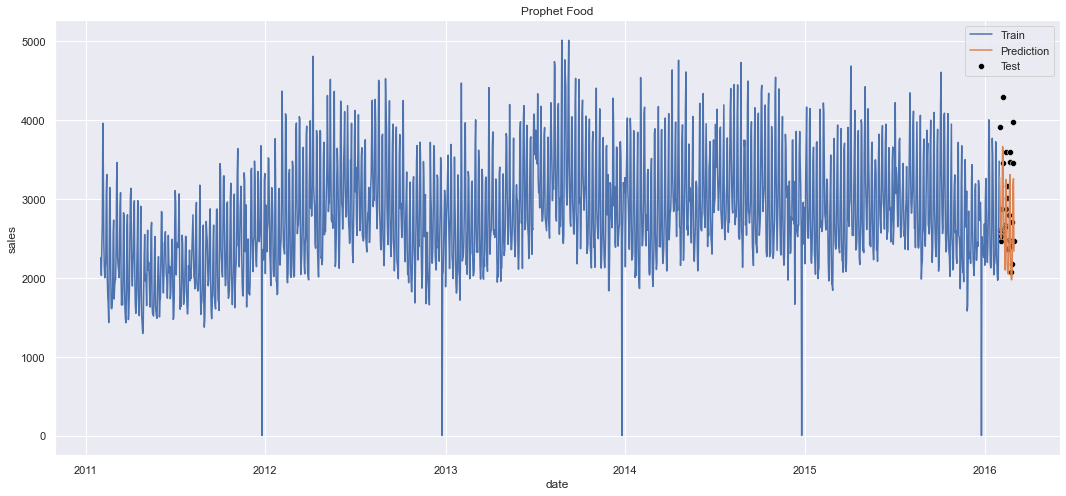

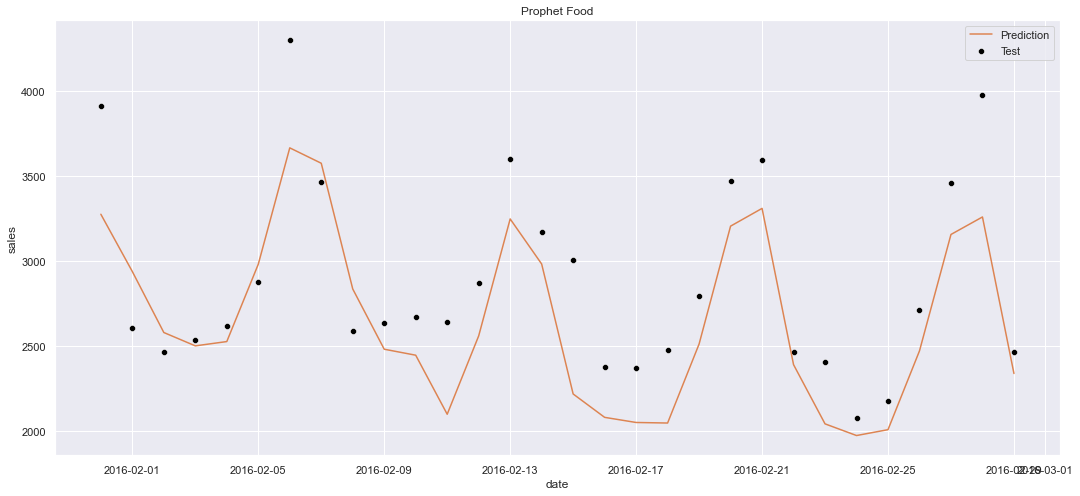

RMSE:	 352.66


In [13]:
# Modellierung Food

# Food-Datensatz splitten
train_food, test_food = temporal_train_test_split(food_grouped, test_size = 30)

# Prophet Data Frame kreiren
df_prophet_food = pd.DataFrame(food_grouped['sales'].astype('float'))
df_prophet_food.reset_index(inplace = True)
df_prophet_food.columns = ['ds', 'y']
display(df_prophet_food)
#display(df_prophet_food.info())

# Data Frame splitten
data_train_food, data_test_food = temporal_train_test_split(df_prophet_food, test_size = 30)

# Erklärende Variablen initialisieren auf Basis der Feature Importance
data_train_food['mean_price_dept2'] = train_food['mean_price_dept2'].astype('float').to_numpy()
data_train_food['snap'] = train_food['snap'].astype('int').to_numpy() #
data_train_food['mean_price_dept3'] = train_food['mean_price_dept3'].astype('float').to_numpy()
data_train_food['mean_price_dept1'] = train_food['mean_price_dept1'].astype('float').to_numpy()
data_train_food['Month_April'] = train_food['Month_April'].astype('int').to_numpy()
data_train_food['Month_August'] = train_food['Month_August'].astype('int').to_numpy()
data_train_food['Month_December'] = train_food['Month_December'].astype('int').to_numpy()
data_train_food['Month_February'] = train_food['Month_February'].astype('int').to_numpy()
data_train_food['Month_January'] = train_food['Month_January'].astype('int').to_numpy()
data_train_food['Month_July'] = train_food['Month_July'].astype('int').to_numpy()
data_train_food['Month_June'] = train_food['Month_June'].astype('int').to_numpy()
data_train_food['Month_May'] = train_food['Month_May'].astype('int').to_numpy()
data_train_food['Month_November'] = train_food['Month_November'].astype('int').to_numpy()
data_train_food['Month_October'] = train_food['Month_October'].astype('int').to_numpy()
data_train_food['Month_September'] = train_food['Month_September'].astype('int').to_numpy()
data_train_food['Weekday_Friday'] = train_food['Weekday_Friday'].astype('int').to_numpy()
data_train_food['Weekday_Monday'] = train_food['Weekday_Monday'].astype('int').to_numpy()
data_train_food['Weekday_Saturday'] = train_food['Weekday_Saturday'].astype('int').to_numpy()
data_train_food['Weekday_Sunday'] = train_food['Weekday_Sunday'].astype('int').to_numpy()
data_train_food['Weekday_Wednesday'] = train_food['Weekday_Wednesday'].astype('int').to_numpy()
#display(data_train_food)
#data_train_food.to_excel("food_train.xlsx")

# Prophet Modellierung
p_food = Prophet(yearly_seasonality = True, weekly_seasonality = True, holidays = holidays)
p_food.add_regressor('mean_price_dept1')
p_food.add_regressor('mean_price_dept2')
p_food.add_regressor('mean_price_dept3')
p_food.add_regressor('snap')
p_food.add_regressor('Month_April')
p_food.add_regressor('Month_August')
p_food.add_regressor('Month_December')
p_food.add_regressor('Month_February')
p_food.add_regressor('Month_January')
p_food.add_regressor('Month_July')
p_food.add_regressor('Month_June')
p_food.add_regressor('Month_May')
p_food.add_regressor('Month_November')
p_food.add_regressor('Month_October')
p_food.add_regressor('Month_September')
p_food.add_regressor('Weekday_Friday')
p_food.add_regressor('Weekday_Monday')
p_food.add_regressor('Weekday_Saturday')
p_food.add_regressor('Weekday_Sunday')
p_food.add_regressor('Weekday_Wednesday')
p_food.fit(data_train_food)

future_food = p_food.make_future_dataframe(periods = len(test_food), freq='D', include_history = False)
future_food['mean_price_dept1'] = test_food['mean_price_dept1'].to_numpy()
future_food['mean_price_dept2'] = test_food['mean_price_dept2'].to_numpy()
future_food['mean_price_dept3'] = test_food['mean_price_dept3'].to_numpy()
future_food['snap'] = test_food['snap'].to_numpy()
future_food['Month_April'] = test_food['Month_April'].to_numpy()
future_food['Month_August'] = test_food['Month_August'].to_numpy()
future_food['Month_December'] = test_food['Month_December'].to_numpy()
future_food['Month_February'] = test_food['Month_February'].to_numpy()
future_food['Month_January'] = test_food['Month_January'].to_numpy()
future_food['Month_July'] = test_food['Month_July'].to_numpy()
future_food['Month_June'] = test_food['Month_June'].to_numpy()
future_food['Month_May'] = test_food['Month_May'].to_numpy()
future_food['Month_November'] = test_food['Month_November'].to_numpy()
future_food['Month_October'] = test_food['Month_October'].to_numpy()
future_food['Month_September'] = test_food['Month_September'].to_numpy()
future_food['Weekday_Friday'] = test_food['Weekday_Friday'].to_numpy()
future_food['Weekday_Monday'] = test_food['Weekday_Monday'].to_numpy()
future_food['Weekday_Saturday'] = test_food['Weekday_Saturday'].to_numpy()
future_food['Weekday_Sunday'] = test_food['Weekday_Sunday'].to_numpy()
future_food['Weekday_Wednesday'] = test_food['Weekday_Wednesday'].to_numpy()
#display(future_food)

forecast_food = p_food.predict(future_food)
forecast_food.set_index('ds', inplace = True)
#display(forecast_food)

sns.lineplot(data = train_food['sales'], label = 'Train')
sns.scatterplot(data = test_food['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast_food['yhat'], label = 'Prediction')
plt.title('Prophet Food')
plt.show()

sns.scatterplot(data = test_food['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast_food['yhat'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Prophet Food')
plt.show()

Prophet_MSE_Food = MSE(y_true = test_food['sales'], y_pred = forecast_food['yhat'])
Prophet_RMSE_Food = sqrt(Prophet_MSE_Food)
print('RMSE:\t %4.2f' % Prophet_RMSE_Food)

Der Zeitverlauf der Testdaten ähnelt dem der tatsächlichen Werte gemäß dem Wochenrhytmus, allerdings schafft es Prophet nicht die alle Spitzen und Tiefpunkte der Food-Kategorie genau abzubilden (z.B. den Superbowl am 7. Februar).

In [14]:
# Evaluation Food (Kreuzvalidierung)

# Initial = Anzahl Trainingsdaten
# Period = Schrittweise Erweiterung des Prognoseintervalls
# Horizon = Prognoseintervall gemäß Test-Size

display(data_train_food.value_counts('ds'))
scores_food = cross_validation(p_food, initial='1500 days', period='30 days', horizon ='30 days')
metrics_food = performance_metrics(scores_food)
display(metrics_food[['horizon', 'rmse']])

#print('RMSE:\t %4.2f' % (metrics_food['rmse'].mean())

Prophet_CV_RMSE_Food = metrics_food['rmse'].mean()
print(Prophet_CV_RMSE_Food)

ds
2011-02-01    1
2014-06-11    1
2014-06-09    1
2014-06-08    1
2014-06-07    1
             ..
2012-09-28    1
2012-09-27    1
2012-09-26    1
2012-09-25    1
2016-01-30    1
Length: 1825, dtype: int64

INFO:prophet:Making 10 forecasts with cutoffs between 2015-04-05 00:00:00 and 2015-12-31 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


,horizon,rmse
0,3 days,312.890028
1,4 days,260.017495
2,5 days,267.393195
3,6 days,250.392084
4,7 days,224.754078
5,8 days,156.672012
6,9 days,199.494061
7,10 days,253.835077
8,11 days,275.002078
9,12 days,260.460101


308.44530055901896


Der durchschnittliche RMSE aus der Kreuzvalidierung der Food-Kategorie beträgt 313.52 über einen Vorhersage-Horizont von 30 Tagen.

#### B. Modellierung der Hobbies-Zeitreihe in Prophet

,ds,y
0,2011-02-01,392.0
1,2011-02-02,268.0
2,2011-02-03,467.0
3,2011-02-04,346.0
4,2011-02-05,769.0
...,...,...
1850,2016-02-25,451.0
1851,2016-02-26,525.0
1852,2016-02-27,600.0
1853,2016-02-28,740.0


<ipython-input-15-27fb53097f8e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_hobbies['mean_price_dept1'] = train_hobbies['mean_price_dept1'].astype('float').to_numpy()
<ipython-input-15-27fb53097f8e>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_hobbies['mean_price_dept2'] = train_hobbies['mean_price_dept2'].astype('float').to_numpy()
<ipython-input-15-27fb53097f8e>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

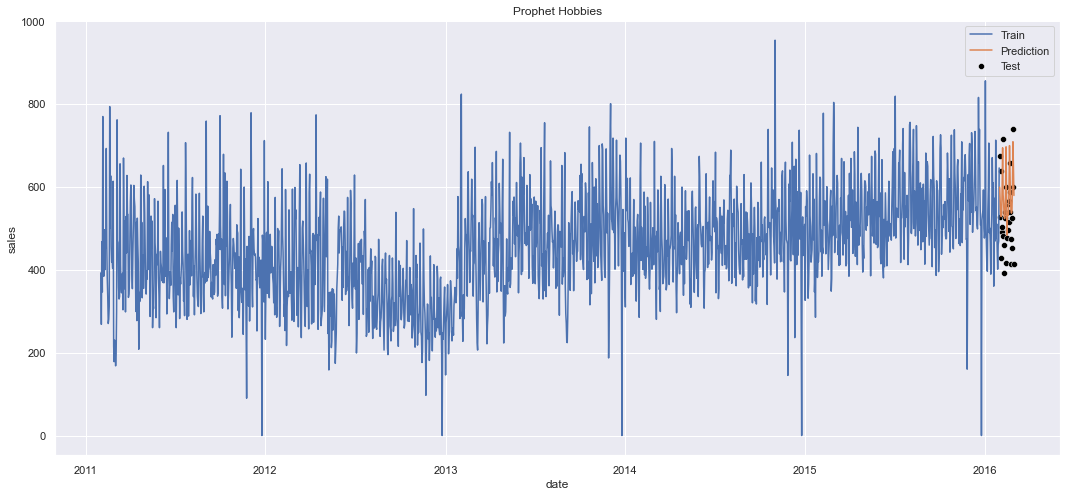

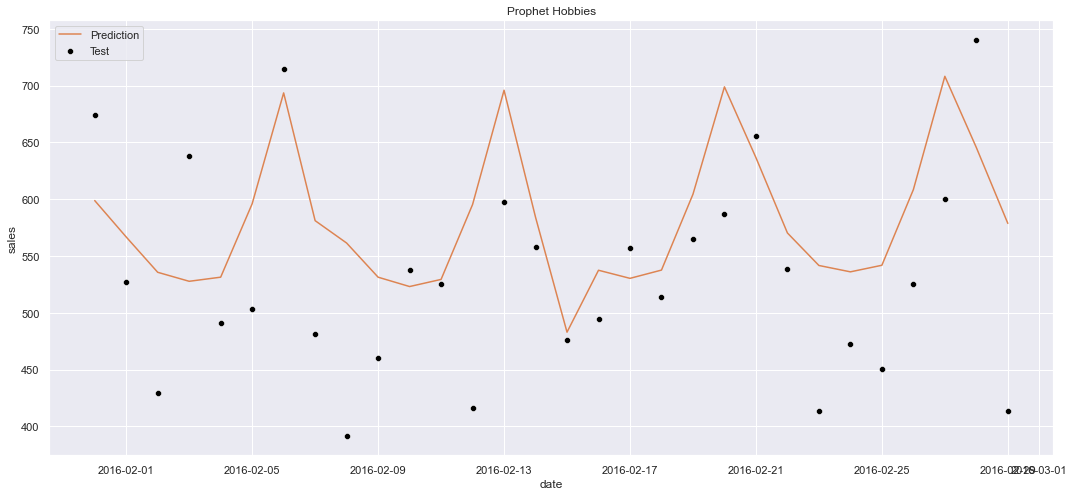

RMSE:	 87.53


In [15]:
# Modellierung Hobbies

# Hobbies-Datensatz splitten
train_hobbies, test_hobbies = temporal_train_test_split(hobbies_grouped, test_size = 30)

# Prophet Data Frame kreiren
df_prophet_hobbies = pd.DataFrame(hobbies_grouped['sales'].astype('float'))
df_prophet_hobbies.reset_index(inplace = True)
df_prophet_hobbies.columns = ['ds', 'y']
display(df_prophet_hobbies)
#display(df_prophet_hobbies.info())

# Data Frame splitten
data_train_hobbies, data_test_hobbies = temporal_train_test_split(df_prophet_hobbies, test_size = 30)

# Erklärende Variablen initialisieren auf Basis der Feature Importance
data_train_hobbies['mean_price_dept1'] = train_hobbies['mean_price_dept1'].astype('float').to_numpy()
data_train_hobbies['mean_price_dept2'] = train_hobbies['mean_price_dept2'].astype('float').to_numpy() 
data_train_hobbies['Month_December'] = train_hobbies['Month_December'].astype('int').to_numpy()
#data_train_hobbies['Month_April'] = train_hobbies['Month_April'].astype('int').to_numpy()
data_train_hobbies['Month_February'] = train_hobbies['Month_February'].astype('int').to_numpy()
#data_train_hobbies['Month_January'] = train_hobbies['Month_January'].astype('int').to_numpy()
#data_train_hobbies['Month_July'] = train_hobbies['Month_July'].astype('int').to_numpy()
#data_train_hobbies['Month_June'] = train_hobbies['Month_June'].astype('int').to_numpy()
#data_train_hobbies['Month_March'] = train_hobbies['Month_March'].astype('int').to_numpy()
#data_train_hobbies['Month_November'] = train_hobbies['Month_November'].astype('int').to_numpy()
#data_train_hobbies['Month_September'] = train_hobbies['Month_September'].astype('int').to_numpy()
data_train_hobbies['Weekday_Friday'] = train_hobbies['Weekday_Friday'].astype('int').to_numpy()
data_train_hobbies['Weekday_Monday'] = train_hobbies['Weekday_Monday'].astype('int').to_numpy()
data_train_hobbies['Weekday_Saturday'] = train_hobbies['Weekday_Saturday'].astype('int').to_numpy()
data_train_hobbies['Weekday_Sunday'] = train_hobbies['Weekday_Sunday'].astype('int').to_numpy()
#display(data_train_hobbies)
#data_train_hobbies.to_excel("hobbies_train.xlsx")

# Prophet Modellierung
p_hobbies = Prophet(yearly_seasonality = True, weekly_seasonality = True, holidays = holidays)
p_hobbies.add_regressor('mean_price_dept1')
p_hobbies.add_regressor('mean_price_dept2')
p_hobbies.add_regressor('Month_December')
#p_hobbies.add_regressor('Month_April')
p_hobbies.add_regressor('Month_February')
#p_hobbies.add_regressor('Month_January')
#p_hobbies.add_regressor('Month_July')
#p_hobbies.add_regressor('Month_June')
#p_hobbies.add_regressor('Month_March')
#p_hobbies.add_regressor('Month_November')
#p_hobbies.add_regressor('Month_September')
p_hobbies.add_regressor('Weekday_Friday')
p_hobbies.add_regressor('Weekday_Monday')
p_hobbies.add_regressor('Weekday_Saturday')
p_hobbies.add_regressor('Weekday_Sunday')
p_hobbies.fit(data_train_hobbies)

future_hobbies = p_hobbies.make_future_dataframe(periods = len(test_hobbies), freq='D', include_history = False)
future_hobbies['mean_price_dept1'] = test_hobbies['mean_price_dept1'].to_numpy()
future_hobbies['mean_price_dept2'] = test_hobbies['mean_price_dept2'].to_numpy()
future_hobbies['Month_December'] = test_hobbies['Month_December'].to_numpy()
#future_hobbies['Month_April'] = test_hobbies['Month_April'].to_numpy()
future_hobbies['Month_February'] = test_hobbies['Month_February'].to_numpy()
#future_hobbies['Month_January'] = test_hobbies['Month_January'].to_numpy()
#future_hobbies['Month_July'] = test_hobbies['Month_July'].to_numpy()
#future_hobbies['Month_June'] = test_hobbies['Month_June'].to_numpy()
#future_hobbies['Month_March'] = test_hobbies['Month_March'].to_numpy()
#future_hobbies['Month_November'] = test_hobbies['Month_November'].to_numpy()
#future_hobbies['Month_September'] = test_hobbies['Month_September'].to_numpy()
future_hobbies['Weekday_Friday'] = test_hobbies['Weekday_Friday'].to_numpy()
future_hobbies['Weekday_Monday'] = test_hobbies['Weekday_Monday'].to_numpy()
future_hobbies['Weekday_Saturday'] = test_hobbies['Weekday_Saturday'].to_numpy()
future_hobbies['Weekday_Sunday'] = test_hobbies['Weekday_Sunday'].to_numpy()
#display(future_hobbies)

forecast_hobbies = p_hobbies.predict(future_hobbies)
forecast_hobbies.set_index('ds', inplace = True)
#display(forecast_hobbies)

sns.lineplot(data = train_hobbies['sales'], label = 'Train')
sns.scatterplot(data = test_hobbies['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast_hobbies['yhat'], label = 'Prediction')
plt.title('Prophet Hobbies')
plt.show()

sns.scatterplot(data = test_hobbies['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast_hobbies['yhat'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Prophet Hobbies')
plt.show()

#print('MAE:\t %4.2f' % (MAE(y_true = test_hobbies['sales'], y_pred = forecast_hobbies['yhat'])))
Prophet_MSE_Hobbies = MSE(y_true = test_hobbies['sales'], y_pred = forecast_hobbies['yhat'])
Prophet_RMSE_Hobbies = sqrt(Prophet_MSE_Hobbies)
print('RMSE:\t %4.2f' % Prophet_RMSE_Hobbies)

In [16]:
# Evaluation Hobbies (Kreuzvalidierung)

# Initial = Anzahl Trainingsdaten
# Period = Schrittweise Erweiterung des Prognoseintervalls
# Horizon = Prognoseintervall gemäß Test-Size

display(data_train_hobbies.value_counts('ds'))
scores_hobbies = cross_validation(p_hobbies, initial='1500 days', period='30 days', horizon ='30 days')
metrics_hobbies = performance_metrics(scores_hobbies)
display(metrics_hobbies[['horizon', 'rmse']])

#print('RMSE:\t %4.2f' % (metrics_hobbies['rmse'].mean())

Prophet_CV_RMSE_Hobbies = metrics_hobbies['rmse'].mean()
print(Prophet_CV_RMSE_Hobbies)

ds
2011-02-01    1
2014-06-11    1
2014-06-09    1
2014-06-08    1
2014-06-07    1
             ..
2012-09-28    1
2012-09-27    1
2012-09-26    1
2012-09-25    1
2016-01-30    1
Length: 1825, dtype: int64

INFO:prophet:Making 10 forecasts with cutoffs between 2015-04-05 00:00:00 and 2015-12-31 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


,horizon,rmse
0,3 days,78.989655
1,4 days,71.646493
2,5 days,75.234151
3,6 days,82.606696
4,7 days,79.855356
5,8 days,75.598703
6,9 days,70.628410
7,10 days,73.867964
8,11 days,60.180822
9,12 days,60.957905


79.57232342037382


Der durchschnittliche RMSE aus der Kreuzvalidierung der Hobbies-Kategorie beträgt 79.37 über einen Vorhersage-Horizont von 30 Tagen. Damit ist die Modell-Performance erkennbar besser als bei der Food-Kategorie.

#### C. Modellierung der Household-Zeitreihe in Prophet

,ds,y
0,2011-02-01,401.0
1,2011-02-02,330.0
2,2011-02-03,402.0
3,2011-02-04,411.0
4,2011-02-05,706.0
...,...,...
1850,2016-02-25,769.0
1851,2016-02-26,849.0
1852,2016-02-27,1270.0
1853,2016-02-28,1479.0


<ipython-input-17-26e8fa22d688>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_household['mean_price_dept1'] = train_household['mean_price_dept1'].astype('float').to_numpy()
<ipython-input-17-26e8fa22d688>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train_household['mean_price_dept2'] = train_household['mean_price_dept2'].astype('float').to_numpy()
<ipython-input-17-26e8fa22d688>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

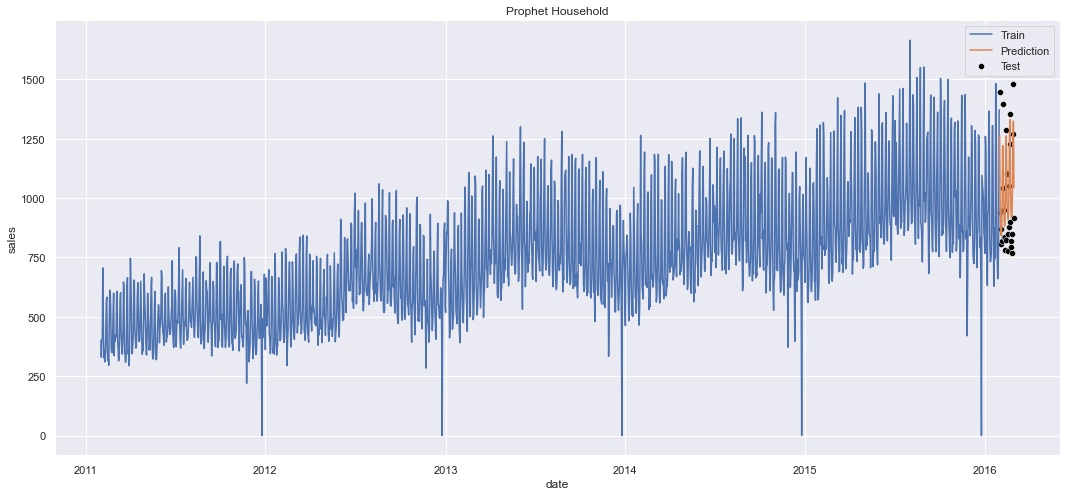

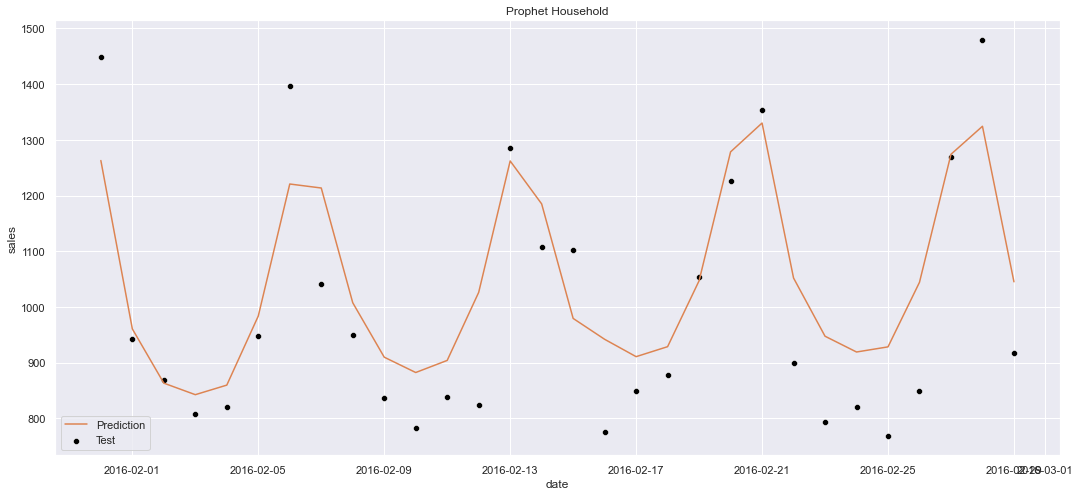

RMSE:	 112.91


In [17]:
# Modellierung Household

# Household-Datensatz splitten
train_household, test_household = temporal_train_test_split(household_grouped, test_size = 30)

# Prophet Data Frame kreiren
df_prophet_household = pd.DataFrame(household_grouped['sales'].astype('float'))
df_prophet_household.reset_index(inplace = True)
df_prophet_household.columns = ['ds', 'y']
display(df_prophet_household)
#display(df_prophet_household.info())

# Data Frame splitten
data_train_household, data_test_household = temporal_train_test_split(df_prophet_household, test_size = 30)

# Erklärende Variablen initialisieren auf Basis der Feature Importance
data_train_household['mean_price_dept1'] = train_household['mean_price_dept1'].astype('float').to_numpy()
data_train_household['mean_price_dept2'] = train_household['mean_price_dept2'].astype('float').to_numpy()
data_train_household['Month_December'] = train_household['Month_December'].astype('int').to_numpy()
data_train_household['Month_August'] = train_household['Month_August'].astype('int').to_numpy()
#data_train_household['Month_May'] = train_household['Month_May'].astype('int').to_numpy()
data_train_household['Month_January'] = train_household['Month_January'].astype('int').to_numpy()
data_train_household['Month_July'] = train_household['Month_July'].astype('int').to_numpy()
data_train_household['Weekday_Friday'] = train_household['Weekday_Friday'].astype('int').to_numpy()
data_train_household['Weekday_Monday'] = train_household['Weekday_Monday'].astype('int').to_numpy()
data_train_household['Weekday_Saturday'] = train_household['Weekday_Saturday'].astype('int').to_numpy()
data_train_household['Weekday_Sunday'] = train_household['Weekday_Sunday'].astype('int').to_numpy()
#display(data_train_household)
#data_train_household.to_excel("household_train.xlsx")

# Prophet Modellierung
p_household = Prophet(yearly_seasonality = True, weekly_seasonality = True, holidays = holidays)
p_household.add_regressor('mean_price_dept1')
p_household.add_regressor('mean_price_dept2')
p_household.add_regressor('Month_December')
p_household.add_regressor('Month_August')
#p_household.add_regressor('Month_May')
p_household.add_regressor('Month_January')
p_household.add_regressor('Month_July')
p_household.add_regressor('Weekday_Friday')
p_household.add_regressor('Weekday_Monday')
p_household.add_regressor('Weekday_Saturday')
p_household.add_regressor('Weekday_Sunday')
p_household.fit(data_train_household)

future_household = p_household.make_future_dataframe(periods = len(test_household), freq='D', include_history = False)
future_household['mean_price_dept1'] = test_household['mean_price_dept1'].to_numpy()
future_household['mean_price_dept2'] = test_household['mean_price_dept2'].to_numpy()
future_household['Month_December'] = test_household['Month_December'].to_numpy()
future_household['Month_April'] = test_household['Month_April'].to_numpy()
future_household['Month_August'] = test_household['Month_August'].to_numpy()
#future_household['Month_May'] = test_household['Month_May'].to_numpy()
future_household['Month_January'] = test_household['Month_January'].to_numpy()
future_household['Month_July'] = test_household['Month_July'].to_numpy()
future_household['Weekday_Friday'] = test_household['Weekday_Friday'].to_numpy()
future_household['Weekday_Monday'] = test_household['Weekday_Monday'].to_numpy()
future_household['Weekday_Saturday'] = test_household['Weekday_Saturday'].to_numpy()
future_household['Weekday_Sunday'] = test_household['Weekday_Sunday'].to_numpy()
#display(future_household)

forecast_household = p_household.predict(future_household)
forecast_household.set_index('ds', inplace = True)
#display(forecast_household)
#forecast_household.to_excel("fcst_household.xlsx")

sns.lineplot(data = train_household['sales'], label = 'Train')
sns.scatterplot(data = test_household['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast_household['yhat'], label = 'Prediction')
plt.title('Prophet Household')
plt.show()

sns.scatterplot(data = test_household['sales'], color = 'black', label = 'Test')
sns.lineplot(data = forecast_household['yhat'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Prophet Household')
plt.show()

Prophet_MSE_Household = MSE(y_true = test_household['sales'], y_pred = forecast_household['yhat'])
Prophet_RMSE_Household = sqrt(Prophet_MSE_Household)
print('RMSE:\t %4.2f' % Prophet_RMSE_Household)

In [18]:
# Evaluation Household (Kreuzvalidierung)

# Initial = Anzahl Trainingsdaten
# Period = Schrittweise Erweiterung des Prognoseintervalls
# Horizon = Prognoseintervall gemäß Test-Size

display(data_train_household.value_counts('ds'))
scores_household = cross_validation(p_household, initial='1500 days', period='30 days', horizon ='30 days')
metrics_household = performance_metrics(scores_household)
display(metrics_household[['horizon', 'rmse']])

#print('RMSE:\t %4.2f' % (metrics_household['rmse'].mean())

Prophet_CV_RMSE_Household = metrics_household['rmse'].mean()
print(Prophet_CV_RMSE_Household)

ds
2011-02-01    1
2014-06-11    1
2014-06-09    1
2014-06-08    1
2014-06-07    1
             ..
2012-09-28    1
2012-09-27    1
2012-09-26    1
2012-09-25    1
2016-01-30    1
Length: 1825, dtype: int64

INFO:prophet:Making 10 forecasts with cutoffs between 2015-04-05 00:00:00 and 2015-12-31 00:00:00


  0%|          | 0/10 [00:00<?, ?it/s]

INFO:prophet:Skipping MAPE because y close to 0


,horizon,rmse
0,3 days,86.784086
1,4 days,77.597381
2,5 days,90.513591
3,6 days,96.476886
4,7 days,104.547671
5,8 days,90.659429
6,9 days,92.439868
7,10 days,85.622128
8,11 days,96.342008
9,12 days,92.700430


112.7976890798898



Der durchschnittliche RMSE aus der Kreuzvalidierung der Household-Kategorie beträgt 110.99 über einen Vorhersage-Horizont von 30 Tagen. Auch dieses Modell erweist sich als genauer als bei der Food-Kategorie, performt aber schlechter als bei der Hobbies-Zeitreihe.

#### D. Aggregation der Zeitreihen und Visualisierung


Um die Gesamtperformance der einzelnen Vorhersagen zu bewerten, gilt es die Testdaten zu aggregieren und vergleichend mit dem Gesamtabsatz zu visualisieren.

,Food,Hobbies,Household,Total
2011-02-01,2258,392,401,3051
2011-02-02,2032,268,330,2630
2011-02-03,2407,467,402,3276
2011-02-04,2693,346,411,3450
2011-02-05,3962,769,706,5437
...,...,...,...,...
2016-02-25,2009,541,928,3479
2016-02-26,2472,608,1044,4125
2016-02-27,3157,708,1274,5139
2016-02-28,3260,645,1324,5230


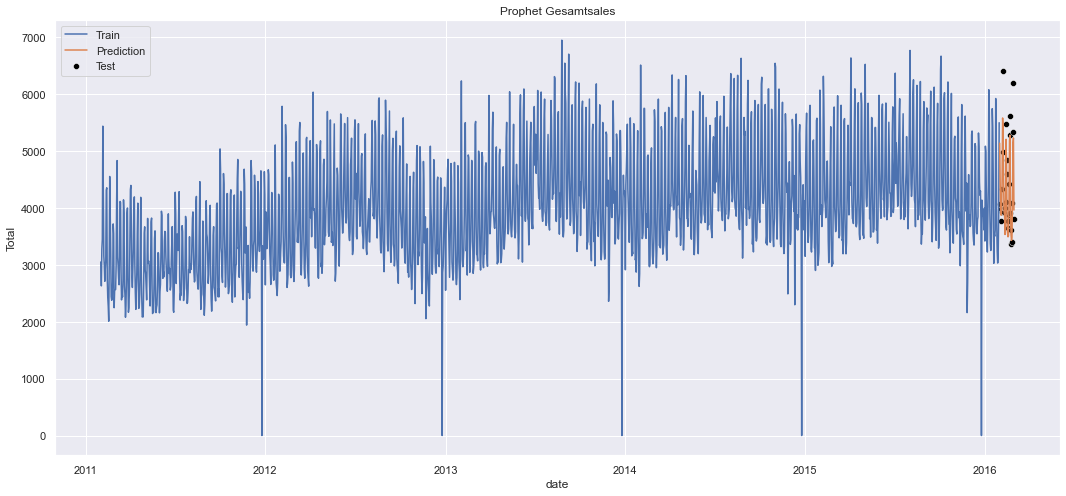

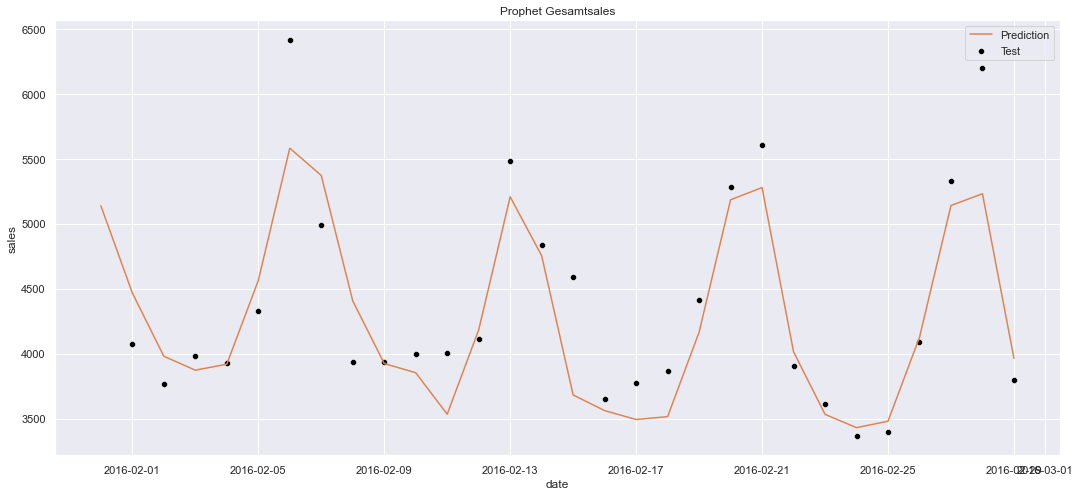

RMSE_Prophet_Gesamt:	 166.94


In [19]:
# Aggregation der Zeitreihen zu einer Gesamt-Zeitreihe & Visualisierung

# Trainingdaten
#display(train_food['sales'])
#display(train_hobbies['sales'])
#display(train_household['sales'])
prophet_train_agg = pd.merge(train_food['sales'], train_hobbies['sales'], on= "date")
prophet_train_agg = pd.merge(prophet_train_agg, train_household['sales'], on='date')
prophet_train_agg['Total'] = prophet_train_agg.sum(axis=1)
prophet_train_agg = prophet_train_agg.rename(columns={"sales_x": "Food", "sales_y": "Hobbies", "sales": "Household"})
#display(prophet_train_agg)

# Testdaten
#display(food['yhat'])
#display(forecast_hobbies['yhat'])
#display(forecast_household['yhat'])
prophet_test_agg = pd.merge(forecast_food['yhat'], forecast_hobbies['yhat'], on= "ds")
prophet_test_agg = pd.merge(prophet_test_agg, forecast_household['yhat'], on='ds')
prophet_test_agg['Total'] = prophet_test_agg.sum(axis=1)
prophet_test_agg = prophet_test_agg.rename(columns={"yhat_x": "Food", "yhat_y": "Hobbies", "yhat": "Household"})
#display(prophet_test_agg)

# Trainings- und Testdaten untereinander mergen
prophet_total_agg = prophet_train_agg.append(prophet_test_agg)
prophet_total_agg = prophet_total_agg.astype('int')
display(prophet_total_agg)

# Visualisierung
data_february = data_grouped.loc['2016-02-01':'2016-02-29']
#display(data_february)
sns.lineplot(data = prophet_train_agg['Total'], label = 'Train')
sns.scatterplot(data = data_february['sales'], color = 'black', label = 'Test')
sns.lineplot(data = prophet_test_agg['Total'], label = 'Prediction')
plt.title('Prophet Gesamtsales')
plt.show()

sns.scatterplot(data = data_february['sales'], color = 'black', label = 'Test')
sns.lineplot(data = prophet_test_agg['Total'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Prophet Gesamtsales')
plt.show()

# Durchschnittler RMSE aus der CV
print('RMSE_Prophet_Gesamt:\t %4.2f' % ((Prophet_CV_RMSE_Food + Prophet_CV_RMSE_Hobbies + Prophet_CV_RMSE_Household)/3))

Die Abbildung der Gesamtzeitreihe von Prophet scheint den wöchentlichen Verlauf im Februar grundsätzlich gut zu schätzen. Allerdings bleibt es auch hier nicht aus, das bestimmte Ausreißer nicht genau erkannt werden. Der durchschnittliche RMSE aller Modelle liegt daher bei 167.66, welcher insbesondere durch Defizite der Food-Modellierung getrieben ist.

### 3.7 Evaluation

Im nächsten Schritt werden die einzelnen Modelle anhand ihrer Prognosegenauigkeit bewertet. Als Bewertungskriterium wurde hierfür die Kennzahl Root Mean Squared Error herangezogen, welcher für die einzelnen Modelle für die jeweilige Kategorie und als Gesamtwert abgebildet wird.
Es wird ersichtlich, dass das Modell mit Prophet den besten RMSE-Wert besitzt, weshalb dieses für die Absatzprognose implementiert wird.

In [ ]:
#Liste mit den jeweiligen Werten der RMSEs erstellen
values_naive = [naive_food_cv,naive_hobbies_cv,naive_household_cv,rmse_naive_ges]
values_reg =     [reg_food_cv, reg_hobbies_cv, reg_household_cv, reg_rmse_gesamt]
values_prophet = [Prophet_CV_RMSE_Food, Prophet_CV_RMSE_Hobbies, Prophet_CV_RMSE_Household, ((Prophet_CV_RMSE_Food + Prophet_CV_RMSE_Hobbies + Prophet_CV_RMSE_Household)/3)]
values_rf =      [rf_cv_food, rf_cv_hobbies, rf_cv_household, ((rf_cv_food + rf_cv_hobbies + rf_cv_household)/3)]
values_exp =  [RMSE_expo_smoothing_food, RMSE_expo_smoothing_hobbies, RMSE_expo_smoothing_household, RMSE_Expo_Smoothing_Gesamt]

In [ ]:
#Listen zu einem Dataframe zusammenfügen
evaluation = pd.DataFrame(list(zip(values_naive, values_reg, values_rf, values_prophet,values_exp)),
               columns =['Einfache Methoden','Lineare Regression', 'Random Forest', 'Prophet', 'Exponentielle Glättung'],
                          index=['Food', 'Hobbies', 'Household', 'Gesamt'])

display(evaluation)

Aus der Betrachtung der jeweiligen RMSEs ergibt sich als bestes Modell Prophet, welches nun für die finale Absatzprognose verwendet wird. Nahezu ebenso gut performen die Modelle Random Forest und Lineare Regression. Auffallend ist, dass alle Modelle bei der Kategorie "Food" am schlechtesten abschneiden. 

In [ ]:
#Forecast Value added berechnen

#alle Modelle gegen einfaches Verfahren
fva_reg_vs_naive = (reg_rmse_gesamt/rmse_naive_ges)
fva_expo_vs_naive = (RMSE_Expo_Smoothing_Gesamt/rmse_naive_ges)
fva_rf_vs_naive = (RMSE_RF_Gesamt/rmse_naive_ges)
fva_prophet_vs_naive = (((Prophet_CV_RMSE_Food + Prophet_CV_RMSE_Hobbies + Prophet_CV_RMSE_Household)/3)/rmse_naive_ges)

print(fva_reg_vs_naive)
print(fva_expo_vs_naive)
print(fva_rf_vs_naive)
print(fva_prophet_vs_naive)

#Modelle gegen exponentielle Glättung
fva_reg_vs_expo = (reg_rmse_gesamt/RMSE_Expo_Smoothing_Gesamt)
fva_rf_vs_expo = (RMSE_RF_Gesamt/RMSE_Expo_Smoothing_Gesamt)
fva_prophet_vs_expo = (((Prophet_CV_RMSE_Food + Prophet_CV_RMSE_Hobbies + Prophet_CV_RMSE_Household)/3)/RMSE_Expo_Smoothing_Gesamt)

print(fva_reg_vs_expo)
print(fva_rf_vs_expo)
print(fva_prophet_vs_expo)

#Modelle gegen lineare Regression
fva_rf_vs_reg = (RMSE_RF_Gesamt/reg_rmse_gesamt)
fva_prophet_vs_reg = (((Prophet_CV_RMSE_Food + Prophet_CV_RMSE_Hobbies + Prophet_CV_RMSE_Household)/3)/reg_rmse_gesamt)

print(fva_rf_vs_reg)
print(fva_prophet_vs_reg)

#Modelle gegen Random Forest
fva_prophet_vs_rf = (((Prophet_CV_RMSE_Food + Prophet_CV_RMSE_Hobbies + Prophet_CV_RMSE_Household)/3)/RMSE_RF_Gesamt)
print(fva_prophet_vs_rf)

| Methode / Verfahren| RMSE (CV)  | FVA vs.<br>Einfache Verfahren | FVA vs.<br>Exp.Smoothing | FVA vs.<br>Lineare Regression| FVA vs.<br> Random Forest | 
| -------------------| -----------| ------------------------- | --------------------------------- | --------------------|------|
| Einfache Verfahren | xxxxxx     |                           |                                   |                     |      |
| Exp. Smoothing     | xxxxx      | 13%                       |                                   |                     |      |
| Lineare Regression | xxxxx      | 52%                       | 45%                               |                             
| Random Forest      | xxxxx      | 55%                       | 48%                               | 5%     
| Prophet            | xxxxx      |




## 4. Absatzprognose

Für die nachfolgende Absatzprognose muss zunchst der Validierungsdatensatz für den Monat März zusammengefügt werden. Hierbei wird ebenso vorgegangen wie bei der Kodierung des Trainings- und Testdatensatzes.

### 4.1 Erstellung des Validierungsdatensatzes

In [21]:
#Datensatz für die Abatzprognose zusammenfügen

forecast_data = pd.merge(prices_data, calendar_data, on ="week_id")

forecast_data.set_index(['date'], inplace = True)
forecast_data.sort_index(axis = 0, ascending = True, inplace = True)
forecast_data = forecast_data.drop(['Unnamed: 0'], axis=1)
forecast_data = forecast_data.loc['2016-03-01':'2016-03-31'] #Datensatz auf März 2016 begrenzen

display(forecast_data)

,item_id,week_id,price,event_name_1,event_type_1,event_name_2,event_type_2,snap
date,,,,,,,,
2016-03-01,HOUSEHOLD_1_188,11605,3.98,NaN,NaN,NaN,NaN,1
2016-03-01,FOODS_2_121,11605,1.58,NaN,NaN,NaN,NaN,1
2016-03-01,FOODS_2_195,11605,3.47,NaN,NaN,NaN,NaN,1
2016-03-01,HOUSEHOLD_1_148,11605,5.92,NaN,NaN,NaN,NaN,1
2016-03-01,FOODS_2_198,11605,8.98,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...
2016-03-31,HOBBIES_1_061,11609,2.83,NaN,NaN,NaN,NaN,0
2016-03-31,FOODS_1_159,11609,4.89,NaN,NaN,NaN,NaN,0
2016-03-31,HOUSEHOLD_2_164,11609,8.47,NaN,NaN,NaN,NaN,0


In [22]:
#Kategorie- und Departmentvariablen basierend auf Item-Spalte einfügen

#Neue, leere Spalten kreieren
forecast_data['dept_id'] = None
forecast_data['cat_id'] = None

#Abgleich mit 'item_id'-Spalte
forecast_data['dept_id'] = pd.np.where(forecast_data.item_id.str.contains("HOUSEHOLD_1"), "HOUSEHOLD_1", 
                     pd.np.where(forecast_data.item_id.str.contains("HOUSEHOLD_2"), "HOUSEHOLD_2",
                     pd.np.where(forecast_data.item_id.str.contains("HOBBIES_1"), "HOBBIES_1",
                     pd.np.where(forecast_data.item_id.str.contains("HOBBIES_2"), "HOBBIES_2",
                     pd.np.where(forecast_data.item_id.str.contains("FOODS_1"), "FOODS_1",
                     pd.np.where(forecast_data.item_id.str.contains("FOODS_2"), "FOODS_2",
                     pd.np.where(forecast_data.item_id.str.contains("FOODS_3"), "FOODS_3", 
                                               'other')))))))

forecast_data['cat_id'] = pd.np.where(forecast_data.item_id.str.contains("HOUSEHOLD"), "HOUSEHOLD", 
                          pd.np.where(forecast_data.item_id.str.contains("HOBBIES"), "HOBBIES",
                          pd.np.where(forecast_data.item_id.str.contains("FOODS"), "FOODS", 
                                               'other')))

forecast_data.head()

<ipython-input-22-4c9a51170f1c>:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  forecast_data['dept_id'] = pd.np.where(forecast_data.item_id.str.contains("HOUSEHOLD_1"), "HOUSEHOLD_1",
<ipython-input-22-4c9a51170f1c>:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.where(forecast_data.item_id.str.contains("HOUSEHOLD_2"), "HOUSEHOLD_2",
<ipython-input-22-4c9a51170f1c>:10: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.where(forecast_data.item_id.str.contains("HOBBIES_1"), "HOBBIES_1",
<ipython-input-22-4c9a51170f1c>:11: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  pd.np.where(forecast_data.item_id.str.contains("HOBBIES_2"), 

,item_id,week_id,price,event_name_1,event_type_1,event_name_2,event_type_2,snap,dept_id,cat_id
date,,,,,,,,,,
2016-03-01,HOUSEHOLD_1_188,11605,3.98,NaN,NaN,NaN,NaN,1,HOUSEHOLD_1,HOUSEHOLD
2016-03-01,FOODS_2_121,11605,1.58,NaN,NaN,NaN,NaN,1,FOODS_2,FOODS
2016-03-01,FOODS_2_195,11605,3.47,NaN,NaN,NaN,NaN,1,FOODS_2,FOODS
2016-03-01,HOUSEHOLD_1_148,11605,5.92,NaN,NaN,NaN,NaN,1,HOUSEHOLD_1,HOUSEHOLD
2016-03-01,FOODS_2_198,11605,8.98,NaN,NaN,NaN,NaN,1,FOODS_2,FOODS


In [23]:
#Dummy-variablen codieren
forecast_data['Month'] = forecast_data.index.month_name()
forecast_data['Weekday'] = forecast_data.index.day_name()
forecast_data = pd.get_dummies(forecast_data, columns = ['event_name_1','event_type_1', 'event_name_2', 'event_type_2', 'Month', 'Weekday'], drop_first = False)
forecast_data.head()

,item_id,week_id,price,snap,dept_id,cat_id,event_name_1_Easter,event_name_1_Purim End,event_name_1_StPatricksDay,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious,Month_March,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
date,,,,,,,,,,,,,,,,,,,,,,,
2016-03-01,HOUSEHOLD_1_188,11605,3.98,1,HOUSEHOLD_1,HOUSEHOLD,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2016-03-01,FOODS_2_121,11605,1.58,1,FOODS_2,FOODS,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2016-03-01,FOODS_2_195,11605,3.47,1,FOODS_2,FOODS,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2016-03-01,HOUSEHOLD_1_148,11605,5.92,1,HOUSEHOLD_1,HOUSEHOLD,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
2016-03-01,FOODS_2_198,11605,8.98,1,FOODS_2,FOODS,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [24]:
#Aufteilung pro Kategorie
forecast_food = forecast_data.loc[forecast_data['cat_id'] == 'FOODS']
forecast_household = forecast_data.loc[forecast_data['cat_id'] == 'HOUSEHOLD']
forecast_hobbies = forecast_data.loc[forecast_data['cat_id'] == 'HOBBIES']


In [25]:
forecast_food_agg = forecast_food.groupby('date').apply(

        lambda forecast_food: pd.Series({
            'snap': forecast_food.snap.max(),            
      
            'mean_price_dept1':   forecast_food.loc[forecast_food.dept_id == 'FOODS_1', 'price'].mean(),            
            'mean_price_dept2':   forecast_food.loc[forecast_food.dept_id == 'FOODS_2', 'price'].mean(),
            'mean_price_dept3':   forecast_food.loc[forecast_food.dept_id == 'FOODS_3', 'price'].mean(),
          
            'event_type_1_Cultural' : forecast_food.event_type_1_Cultural.max(), 
            'event_type_1_National': forecast_food.event_type_1_National.max(), 
            'event_type_1_Religious': forecast_food.event_type_1_Religious.max(), 
            'event_type_1_Sporting': forecast_food.event_type_1_Sporting.max(), 
            'event_type_2_Cultural' : forecast_food.event_type_2_Cultural.max(), 
            'event_type_2_Religious': forecast_food.event_type_2_Religious.max(), 
            
            #Anmerkung: Da der Validierungsdatensatz sich nur auf den Monat März bezieht, werden die Dummy-Variablen der anderen Monate automatisch auf Null gesetzt

            'Month_April': 0,
            'Month_August': 0,
            'Month_December': 0,
            'Month_February': 0,
            'Month_January': 0,
            'Month_July': 0,
            'Month_June': 0,
            'Month_March': forecast_food.Month_March.max(),
            'Month_May': 0,
            'Month_November': 0,
            'Month_October': 0,
            'Month_September': 0,
            
            'Weekday_Friday':   forecast_food.Weekday_Friday.max(),
            'Weekday_Monday':   forecast_food.Weekday_Monday.max(),
            'Weekday_Saturday': forecast_food.Weekday_Saturday.max(),
            'Weekday_Sunday':   forecast_food.Weekday_Sunday.max(),
            'Weekday_Thursday': forecast_food.Weekday_Thursday.max(),
            'Weekday_Tuesday':  forecast_food.Weekday_Tuesday.max(),
            'Weekday_Wednesday':forecast_food.Weekday_Wednesday.max()
                               
       }))
forecast_food_agg.head()

,snap,mean_price_dept1,mean_price_dept2,mean_price_dept3,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-03-01,1.0,3.328796,4.230528,2.919368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-03-02,1.0,3.328796,4.230528,2.919368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-03-03,1.0,3.328796,4.230528,2.919368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-03-04,1.0,3.328796,4.230528,2.919368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-05,1.0,3.328796,4.226834,2.922661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [26]:
forecast_household_agg = forecast_household.groupby('date').apply(

        lambda forecast_household: pd.Series({
            'snap': forecast_household.snap.max(),            
      
            'mean_price_dept1':   forecast_household.loc[forecast_household.dept_id == 'HOUSEHOLD_1', 'price'].mean(),            
            'mean_price_dept2':   forecast_household.loc[forecast_household.dept_id == 'HOUSEHOLD_2', 'price'].mean(),
                      
            'event_type_1_Cultural' : forecast_household.event_type_1_Cultural.max(), 
            'event_type_1_National': forecast_household.event_type_1_National.max(), 
            'event_type_1_Religious': forecast_household.event_type_1_Religious.max(), 
            'event_type_1_Sporting': forecast_household.event_type_1_Sporting.max(), 
            'event_type_2_Cultural' : forecast_household.event_type_2_Cultural.max(), 
            'event_type_2_Religious': forecast_household.event_type_2_Religious.max(), 
            
            #Anmerkung: Da der Validierungsdatensatz sich nur auf den Monat März bezieht, werden die Dummy-Variablen der anderen Monate automatisch auf Null gesetzt
            'Month_April': 0,
            'Month_August': 0,
            'Month_December': 0,
            'Month_February': 0,
            'Month_January': 0,
            'Month_July': 0,
            'Month_June': 0,
            'Month_March': forecast_household.Month_March.max(),
            'Month_May': 0,
            'Month_November': 0,
            'Month_October': 0,
            'Month_September': 0,
            
            'Weekday_Friday':   forecast_household.Weekday_Friday.max(),
            'Weekday_Monday':   forecast_household.Weekday_Monday.max(),
            'Weekday_Saturday': forecast_household.Weekday_Saturday.max(),
            'Weekday_Sunday':   forecast_household.Weekday_Sunday.max(),
            'Weekday_Thursday': forecast_household.Weekday_Thursday.max(),
            'Weekday_Tuesday':  forecast_household.Weekday_Tuesday.max(),
            'Weekday_Wednesday':forecast_household.Weekday_Wednesday.max()
                               
       }))
forecast_household_agg.head()

,snap,mean_price_dept1,mean_price_dept2,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-03-01,1.0,5.190094,5.777010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-03-02,1.0,5.190094,5.777010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-03-03,1.0,5.190094,5.777010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-03-04,1.0,5.190094,5.777010,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-05,1.0,5.188684,5.777398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [27]:
forecast_hobbies_agg = forecast_hobbies.groupby('date').apply(

        lambda forecast_hobbies: pd.Series({
            'snap': forecast_hobbies.snap.max(),            
      
            'mean_price_dept1':   forecast_hobbies.loc[forecast_hobbies.dept_id == 'HOBBIES_1', 'price'].mean(),            
            'mean_price_dept2':   forecast_hobbies.loc[forecast_hobbies.dept_id == 'HOBBIES_2', 'price'].mean(),
                      
            'event_type_1_Cultural' : forecast_hobbies.event_type_1_Cultural.max(), 
            'event_type_1_National': forecast_hobbies.event_type_1_National.max(), 
            'event_type_1_Religious': forecast_hobbies.event_type_1_Religious.max(), 
            'event_type_1_Sporting': forecast_hobbies.event_type_1_Sporting.max(), 
            'event_type_2_Cultural' : forecast_hobbies.event_type_2_Cultural.max(), 
            'event_type_2_Religious': forecast_hobbies.event_type_2_Religious.max(), 
            
            #Anmerkung: Da der Validierungsdatensatz sich nur auf den Monat März bezieht, werden die Dummy-Variablen der anderen Monate automatisch auf Null gesetzt

            'Month_April': 0,
            'Month_August': 0,
            'Month_December': 0,
            'Month_February': 0,
            'Month_January': 0,
            'Month_July': 0,
            'Month_June': 0,
            'Month_March': forecast_hobbies.Month_March.max(),
            'Month_May': 0,
            'Month_November': 0,
            'Month_October': 0,
            'Month_September': 0,
            
            'Weekday_Friday':   forecast_hobbies.Weekday_Friday.max(),
            'Weekday_Monday':   forecast_hobbies.Weekday_Monday.max(),
            'Weekday_Saturday': forecast_hobbies.Weekday_Saturday.max(),
            'Weekday_Sunday':   forecast_hobbies.Weekday_Sunday.max(),
            'Weekday_Thursday': forecast_hobbies.Weekday_Thursday.max(),
            'Weekday_Tuesday':  forecast_hobbies.Weekday_Tuesday.max(),
            'Weekday_Wednesday':forecast_hobbies.Weekday_Wednesday.max()
                               
       }))
forecast_hobbies_agg.head()

,snap,mean_price_dept1,mean_price_dept2,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_2_Cultural,event_type_2_Religious,Month_April,Month_August,Month_December,Month_February,Month_January,Month_July,Month_June,Month_March,Month_May,Month_November,Month_October,Month_September,Weekday_Friday,Weekday_Monday,Weekday_Saturday,Weekday_Sunday,Weekday_Thursday,Weekday_Tuesday,Weekday_Wednesday
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-03-01,1.0,6.665962,2.575906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2016-03-02,1.0,6.665962,2.575906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2016-03-03,1.0,6.665962,2.575906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-03-04,1.0,6.665962,2.575906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-03-05,1.0,6.644231,2.575906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### 4.2 Abschließende Prognose

Zunächst gilt es den Holiday-Data Frame um die Kalenderdaten aus dem März zu ergänzen, damit diese Events bei der Vorhersage berücksichtigt werden können.

In [28]:
cult_event_1 = pd.DataFrame(forecast_data[forecast_data.event_type_1_Cultural == True]['event_type_1_Cultural'])
cult_event_1.reset_index(inplace = True)
cult_event_1.columns = ['ds', 'holiday']
cult_event_1['holiday'] = 'cultural_event_1'
cult_event_1['lower_window'] = 0
cult_event_1['upper_window'] = 0
cult_event_1_march = cult_event_1.drop_duplicates(keep='first')
#display(cult_event_1_march)

relig_event_1 = pd.DataFrame(forecast_data[forecast_data.event_type_1_Religious == True]['event_type_1_Religious'])
relig_event_1.reset_index(inplace = True)
relig_event_1.columns = ['ds', 'holiday']
relig_event_1['holiday'] = 'relig_event_1'
relig_event_1['lower_window'] = 0
relig_event_1['upper_window'] = 0
relig_event_1_march = relig_event_1.drop_duplicates(keep='first')
#display(relig_event_1_march)

holidays_adj = pd.concat((holidays, cult_event_1_march, relig_event_1_march))
holidays_adj.sort_values(by='ds', inplace=True, ignore_index=False)
holidays_adj.index = range(len(holidays_adj))
display(holidays_adj)

,ds,holiday,lower_window,upper_window
0,2011-02-06,sport_event_1,0,0
1,2011-02-14,cultural_event_1,0,0
2,2011-02-21,national_event_1,0,0
3,2011-03-09,relig_event_1,0,0
4,2011-03-16,relig_event_1,0,0
...,...,...,...,...
153,2016-02-15,national_event_1,0,0
154,2016-02-17,relig_event_1,0,0
155,2016-03-17,cultural_event_1,0,0
156,2016-03-24,relig_event_1,0,0


#### Modellierung der Food-Zeitreihe mit Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


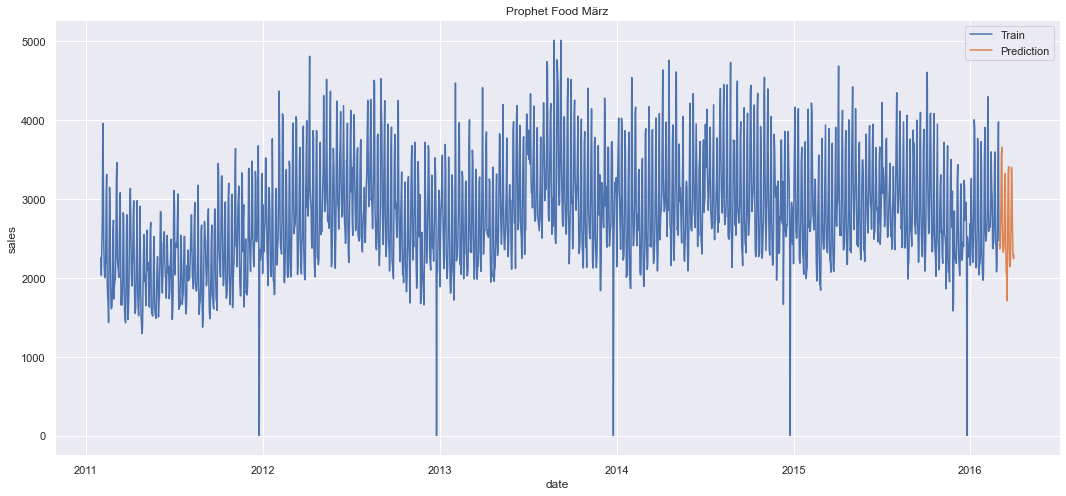

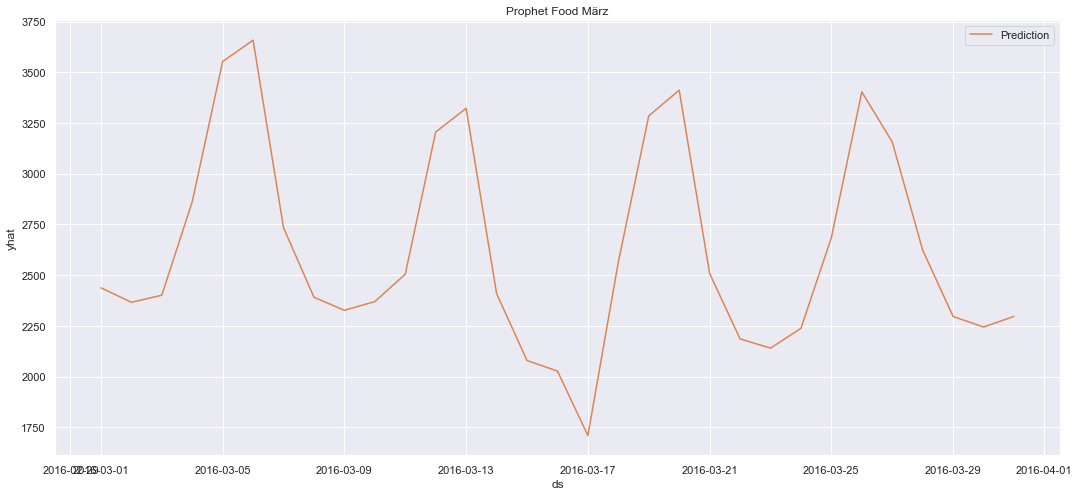

In [29]:
# Modellierung Food

# Prophet Data Frame kreiren
df_prophet_food_2 = pd.DataFrame(food_grouped['sales'].astype('float'))
df_prophet_food_2.reset_index(inplace = True)
df_prophet_food_2.columns = ['ds', 'y']
#display(df_prophet_food_2)

# Ergänze Prohet Data Frame um erklärende Variablen
df_prophet_food_2['mean_price_dept2'] = food_grouped['mean_price_dept2'].astype('float').to_numpy()
df_prophet_food_2['snap'] = food_grouped['snap'].astype('int').to_numpy() #
df_prophet_food_2['mean_price_dept3'] = food_grouped['mean_price_dept3'].astype('float').to_numpy()
df_prophet_food_2['mean_price_dept1'] = food_grouped['mean_price_dept1'].astype('float').to_numpy()
df_prophet_food_2['Month_April'] = food_grouped['Month_April'].astype('int').to_numpy()
df_prophet_food_2['Month_August'] = food_grouped['Month_August'].astype('int').to_numpy()
df_prophet_food_2['Month_December'] = food_grouped['Month_December'].astype('int').to_numpy()
df_prophet_food_2['Month_February'] = food_grouped['Month_February'].astype('int').to_numpy()
df_prophet_food_2['Month_January'] = food_grouped['Month_January'].astype('int').to_numpy()
df_prophet_food_2['Month_July'] = food_grouped['Month_July'].astype('int').to_numpy()
df_prophet_food_2['Month_June'] = food_grouped['Month_June'].astype('int').to_numpy()
df_prophet_food_2['Month_May'] = food_grouped['Month_May'].astype('int').to_numpy()
df_prophet_food_2['Month_November'] = food_grouped['Month_November'].astype('int').to_numpy()
df_prophet_food_2['Month_October'] = food_grouped['Month_October'].astype('int').to_numpy()
df_prophet_food_2['Month_September'] = food_grouped['Month_September'].astype('int').to_numpy()
df_prophet_food_2['Weekday_Friday'] = food_grouped['Weekday_Friday'].astype('int').to_numpy()
df_prophet_food_2['Weekday_Monday'] = food_grouped['Weekday_Monday'].astype('int').to_numpy()
df_prophet_food_2['Weekday_Saturday'] = food_grouped['Weekday_Saturday'].astype('int').to_numpy()
df_prophet_food_2['Weekday_Sunday'] = food_grouped['Weekday_Sunday'].astype('int').to_numpy()
df_prophet_food_2['Weekday_Wednesday'] = food_grouped['Weekday_Wednesday'].astype('int').to_numpy()
#display(df_prophet_food_2)

# Erklärende Variablen aus Gesamtdatensatz einlesen
p_food_2 = Prophet(yearly_seasonality = True, weekly_seasonality = True, holidays = holidays_adj)
p_food_2.add_regressor('mean_price_dept1')
p_food_2.add_regressor('mean_price_dept2')
p_food_2.add_regressor('mean_price_dept3')
p_food_2.add_regressor('snap')
p_food_2.add_regressor('Month_April')
p_food_2.add_regressor('Month_August')
p_food_2.add_regressor('Month_December')
p_food_2.add_regressor('Month_February')
p_food_2.add_regressor('Month_January')
p_food_2.add_regressor('Month_July')
p_food_2.add_regressor('Month_June')
p_food_2.add_regressor('Month_May')
p_food_2.add_regressor('Month_November')
p_food_2.add_regressor('Month_October')
p_food_2.add_regressor('Month_September')
p_food_2.add_regressor('Weekday_Friday')
p_food_2.add_regressor('Weekday_Monday')
p_food_2.add_regressor('Weekday_Saturday')
p_food_2.add_regressor('Weekday_Sunday')
p_food_2.add_regressor('Weekday_Wednesday')
p_food_2.fit(df_prophet_food_2)

future_food_2 = p_food_2.make_future_dataframe(periods = 31, freq='D', include_history = False)

# Erklärende Variablen aus Validierungsdatensatz einlesen
future_food_2['mean_price_dept1'] = forecast_food_agg['mean_price_dept1'].to_numpy()
future_food_2['mean_price_dept2'] = forecast_food_agg['mean_price_dept2'].to_numpy()
future_food_2['mean_price_dept3'] = forecast_food_agg['mean_price_dept3'].to_numpy()
future_food_2['snap'] = forecast_food_agg['snap'].to_numpy()
future_food_2['Month_April'] = forecast_food_agg['Month_April'].to_numpy()
future_food_2['Month_August'] = forecast_food_agg['Month_August'].to_numpy()
future_food_2['Month_December'] = forecast_food_agg['Month_December'].to_numpy()
future_food_2['Month_February'] = forecast_food_agg['Month_February'].to_numpy()
future_food_2['Month_January'] = forecast_food_agg['Month_January'].to_numpy()
future_food_2['Month_July'] = forecast_food_agg['Month_July'].to_numpy()
future_food_2['Month_June'] = forecast_food_agg['Month_June'].to_numpy()
future_food_2['Month_May'] = forecast_food_agg['Month_May'].to_numpy()
future_food_2['Month_November'] = forecast_food_agg['Month_November'].to_numpy()
future_food_2['Month_October'] = forecast_food_agg['Month_October'].to_numpy()
future_food_2['Month_September'] = forecast_food_agg['Month_September'].to_numpy()
future_food_2['Weekday_Friday'] = forecast_food_agg['Weekday_Friday'].to_numpy()
future_food_2['Weekday_Monday'] = forecast_food_agg['Weekday_Monday'].to_numpy()
future_food_2['Weekday_Saturday'] = forecast_food_agg['Weekday_Saturday'].to_numpy()
future_food_2['Weekday_Sunday'] = forecast_food_agg['Weekday_Sunday'].to_numpy()
future_food_2['Weekday_Wednesday'] = forecast_food_agg['Weekday_Wednesday'].to_numpy()
#display(future_food_2)

forecast_food_2 = p_food_2.predict(future_food_2)
forecast_food_2.set_index('ds', inplace = True)
#display(forecast_food_2)

sns.lineplot(data = food_grouped['sales'], label = 'Train')
sns.lineplot(data = forecast_food_2['yhat'], label = 'Prediction')
plt.title('Prophet Food März')
plt.show()

sns.lineplot(data = forecast_food_2['yhat'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Prophet Food März')
plt.show()

# Überarbeiten = Forecast geht nur für 31 Tage, nicht 32 Tage --> 29. Februar muss ins Training

#### Modellierung der Hobbies-Zeitreihe mit Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


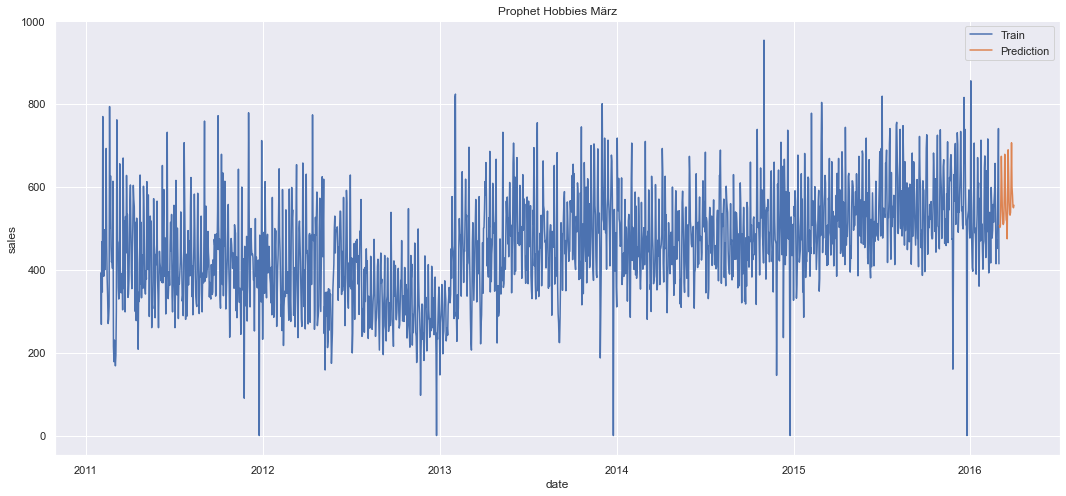

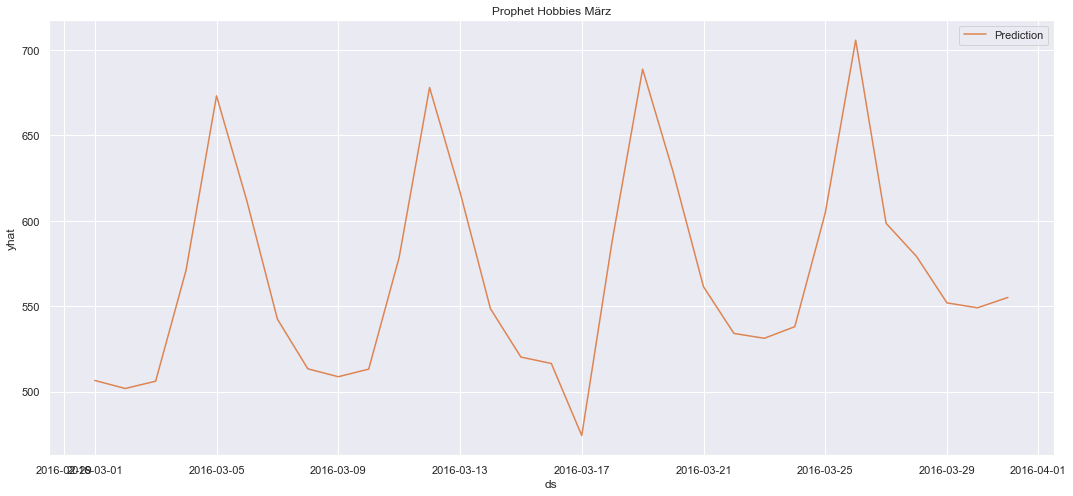

In [30]:
# Modellierung Hobbies

# Prophet Data Frame kreiren
df_prophet_hobbies_2 = pd.DataFrame(hobbies_grouped['sales'].astype('float'))
df_prophet_hobbies_2.reset_index(inplace = True)
df_prophet_hobbies_2.columns = ['ds', 'y']
#display(df_prophet_hobbies_2)

# Ergänze Prohet Data Frame um erklärende Variablen
df_prophet_hobbies_2['mean_price_dept1'] = hobbies_grouped['mean_price_dept1'].astype('float').to_numpy()
df_prophet_hobbies_2['mean_price_dept1'] = hobbies_grouped['mean_price_dept1'].astype('float').to_numpy()
df_prophet_hobbies_2['mean_price_dept2'] = hobbies_grouped['mean_price_dept2'].astype('float').to_numpy() 
df_prophet_hobbies_2['Month_December'] = hobbies_grouped['Month_December'].astype('int').to_numpy()
#df_prophet_hobbies_2['Month_April'] = hobbies_grouped['Month_April'].astype('int').to_numpy()
df_prophet_hobbies_2['Month_February'] = hobbies_grouped['Month_February'].astype('int').to_numpy()
#df_prophet_hobbies_2['Month_January'] = hobbies_grouped['Month_January'].astype('int').to_numpy()
#df_prophet_hobbies_2['Month_July'] = hobbies_grouped['Month_July'].astype('int').to_numpy()
#df_prophet_hobbies_2['Month_June'] = hobbies_grouped['Month_June'].astype('int').to_numpy()
#df_prophet_hobbies_2['Month_March'] = hobbies_grouped['Month_March'].astype('int').to_numpy()
#df_prophet_hobbies_2['Month_November'] = hobbies_grouped['Month_November'].astype('int').to_numpy()
#df_prophet_hobbies_2['Month_September'] = hobbies_grouped['Month_September'].astype('int').to_numpy()
df_prophet_hobbies_2['Weekday_Friday'] = hobbies_grouped['Weekday_Friday'].astype('int').to_numpy()
df_prophet_hobbies_2['Weekday_Monday'] = hobbies_grouped['Weekday_Monday'].astype('int').to_numpy()
df_prophet_hobbies_2['Weekday_Saturday'] = hobbies_grouped['Weekday_Saturday'].astype('int').to_numpy()
df_prophet_hobbies_2['Weekday_Sunday'] = hobbies_grouped['Weekday_Sunday'].astype('int').to_numpy()
#display(df_prophet_hobbies_2)

# Erklärende Variablen aus Gesamtdatensatz einlesen
p_hobbies_2 = Prophet(yearly_seasonality = True, weekly_seasonality = True, holidays = holidays_adj)
p_hobbies_2.add_regressor('mean_price_dept1')
p_hobbies_2.add_regressor('mean_price_dept2')
p_hobbies_2.add_regressor('Month_December')
#p_hobbies_2.add_regressor('Month_April')
p_hobbies_2.add_regressor('Month_February')
#p_hobbies_2.add_regressor('Month_January')
#p_hobbies_2.add_regressor('Month_July')
#p_hobbies_2.add_regressor('Month_June')
#p_hobbies_2.add_regressor('Month_March')
#p_hobbies_2.add_regressor('Month_November')
#p_hobbies_2.add_regressor('Month_September')
p_hobbies_2.add_regressor('Weekday_Friday')
p_hobbies_2.add_regressor('Weekday_Monday')
p_hobbies_2.add_regressor('Weekday_Saturday')
p_hobbies_2.add_regressor('Weekday_Sunday')
p_hobbies_2.fit(df_prophet_hobbies_2)

future_hobbies_2 = p_hobbies_2.make_future_dataframe(periods = 31, freq='D', include_history = False)

# Erklärende Variablen aus Validierungsdatensatz einlesen
future_hobbies_2['mean_price_dept1'] = forecast_hobbies_agg['mean_price_dept1'].to_numpy()
future_hobbies_2['mean_price_dept2'] = forecast_hobbies_agg['mean_price_dept2'].to_numpy()
future_hobbies_2['Month_December'] = forecast_hobbies_agg['Month_December'].to_numpy()
#future_hobbies_2['Month_April'] = forecast_hobbies_agg['Month_April'].to_numpy()
future_hobbies_2['Month_February'] = forecast_hobbies_agg['Month_February'].to_numpy()
#future_hobbies_2['Month_January'] = forecast_hobbies_agg['Month_January'].to_numpy()
#future_hobbies_2['Month_July'] = forecast_hobbies_agg['Month_July'].to_numpy()
#future_hobbies_2['Month_June'] = forecast_hobbies_agg['Month_June'].to_numpy()
#future_hobbies_2['Month_March'] = forecast_hobbies_agg['Month_March'].to_numpy()
#future_hobbies_2['Month_November'] = forecast_hobbies_agg['Month_November'].to_numpy()
#future_hobbies_2['Month_September'] = forecast_hobbies_agg['Month_September'].to_numpy()
future_hobbies_2['Weekday_Friday'] = forecast_hobbies_agg['Weekday_Friday'].to_numpy()
future_hobbies_2['Weekday_Monday'] = forecast_hobbies_agg['Weekday_Monday'].to_numpy()
future_hobbies_2['Weekday_Saturday'] = forecast_hobbies_agg['Weekday_Saturday'].to_numpy()
future_hobbies_2['Weekday_Sunday'] = forecast_hobbies_agg['Weekday_Sunday'].to_numpy()
#display(future_hobbies_2)

forecast_hobbies_2 = p_hobbies_2.predict(future_hobbies_2)
forecast_hobbies_2.set_index('ds', inplace = True)
#display(forecast_hobbies_2)

sns.lineplot(data = hobbies_grouped['sales'], label = 'Train')
sns.lineplot(data = forecast_hobbies_2['yhat'], label = 'Prediction')
plt.title('Prophet Hobbies März')
plt.show()

sns.lineplot(data = forecast_hobbies_2['yhat'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Prophet Hobbies März')
plt.show()

#### Modellierung der Household-Zeitreihe mit Prophet

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


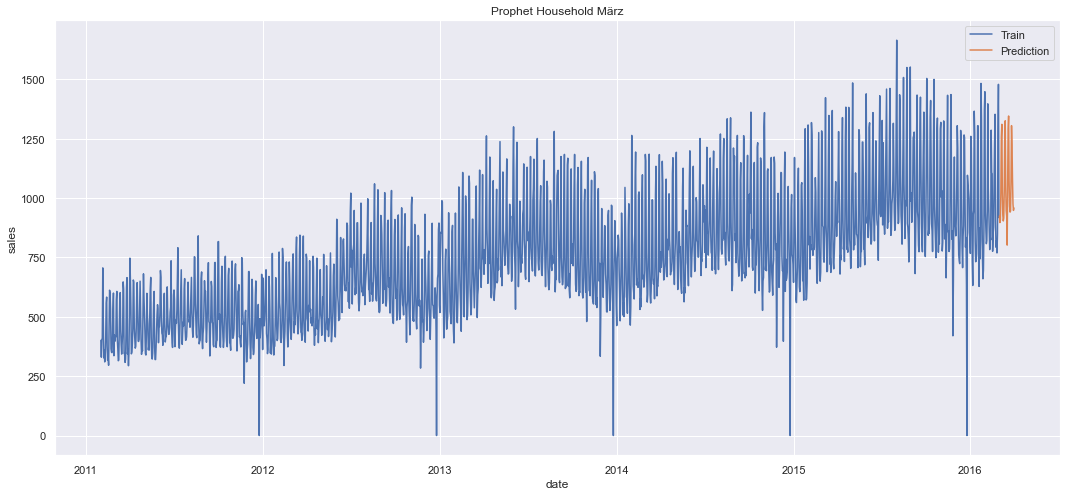

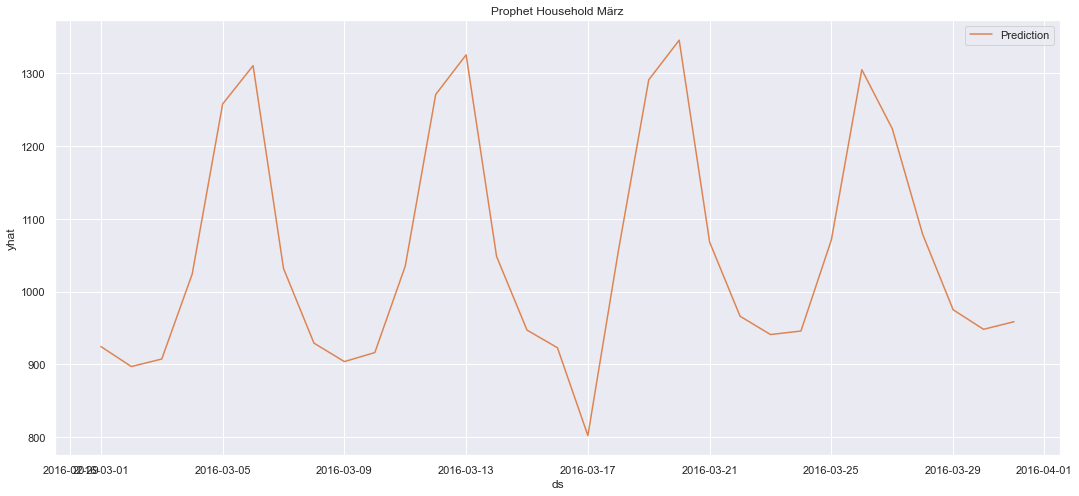

In [31]:
# Modellierung Household

# Prophet Data Frame kreiren
df_prophet_household_2 = pd.DataFrame(household_grouped['sales'].astype('float'))
df_prophet_household_2.reset_index(inplace = True)
df_prophet_household_2.columns = ['ds', 'y']
#display(df_prophet_household_2)

# Ergänze Prohet Data Frame um erklärende Variablen

df_prophet_household_2['mean_price_dept1'] = household_grouped['mean_price_dept1'].astype('float').to_numpy()
df_prophet_household_2['mean_price_dept2'] = household_grouped['mean_price_dept2'].astype('float').to_numpy() 
df_prophet_household_2['Month_December'] = household_grouped['Month_December'].astype('int').to_numpy()
df_prophet_household_2['Month_August'] = household_grouped['Month_August'].astype('int').to_numpy()
#df_prophet_household_2['Month_May'] = household_grouped['Month_May'].astype('int').to_numpy()
df_prophet_household_2['Month_January'] = household_grouped['Month_January'].astype('int').to_numpy()
df_prophet_household_2['Month_July'] = household_grouped['Month_July'].astype('int').to_numpy()
df_prophet_household_2['Weekday_Friday'] = household_grouped['Weekday_Friday'].astype('int').to_numpy()
df_prophet_household_2['Weekday_Monday'] = household_grouped['Weekday_Monday'].astype('int').to_numpy()
df_prophet_household_2['Weekday_Saturday'] = household_grouped['Weekday_Saturday'].astype('int').to_numpy()
df_prophet_household_2['Weekday_Sunday'] = household_grouped['Weekday_Sunday'].astype('int').to_numpy()

#display(df_prophet_household_2)

# Erklärende Variablen aus Gesamtdatensatz einlesen
p_household_2 = Prophet(yearly_seasonality = True, weekly_seasonality = True, holidays = holidays_adj)
p_household_2.add_regressor('mean_price_dept1')
p_household_2.add_regressor('mean_price_dept2')
p_household_2.add_regressor('Month_December')
p_household_2.add_regressor('Month_August')
#p_household_2.add_regressor('Month_May')
p_household_2.add_regressor('Month_January')
p_household_2.add_regressor('Month_July')
p_household_2.add_regressor('Weekday_Friday')
p_household_2.add_regressor('Weekday_Monday')
p_household_2.add_regressor('Weekday_Saturday')
p_household_2.add_regressor('Weekday_Sunday')
p_household_2.fit(df_prophet_household_2)

future_household_2 = p_household_2.make_future_dataframe(periods = 31, freq='D', include_history = False)

# Erklärende Variablen aus Validierungsdatensatz einlesen
future_household_2['mean_price_dept1'] = forecast_household_agg['mean_price_dept1'].to_numpy()
future_household_2['mean_price_dept2'] = forecast_household_agg['mean_price_dept2'].to_numpy()
future_household_2['Month_December'] = forecast_household_agg['Month_December'].to_numpy()
#future_household_2['Month_May'] = forecast_household_agg['Month_May'].to_numpy()
future_household_2['Month_August'] = forecast_household_agg['Month_August'].to_numpy()
future_household_2['Month_January'] = forecast_household_agg['Month_January'].to_numpy()
future_household_2['Month_July'] = forecast_household_agg['Month_July'].to_numpy()
future_household_2['Weekday_Friday'] = forecast_household_agg['Weekday_Friday'].to_numpy()
future_household_2['Weekday_Monday'] = forecast_household_agg['Weekday_Monday'].to_numpy()
future_household_2['Weekday_Saturday'] = forecast_household_agg['Weekday_Saturday'].to_numpy()
future_household_2['Weekday_Sunday'] = forecast_household_agg['Weekday_Sunday'].to_numpy()
#display(future_household_2)

forecast_household_2 = p_household_2.predict(future_household_2)
forecast_household_2.set_index('ds', inplace = True)
#display(forecast_household_2)

sns.lineplot(data = household_grouped['sales'], label = 'Train')
sns.lineplot(data = forecast_household_2['yhat'], label = 'Prediction')
plt.title('Prophet Household März')
plt.show()

sns.lineplot(data = forecast_household_2['yhat'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Prophet Household März')
plt.show()

#### Aggregation der Zeitreihen

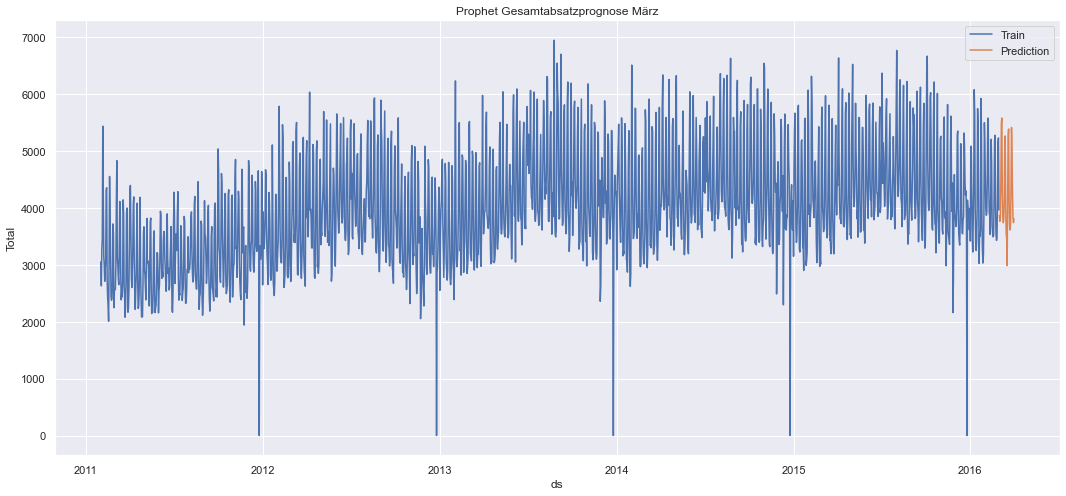

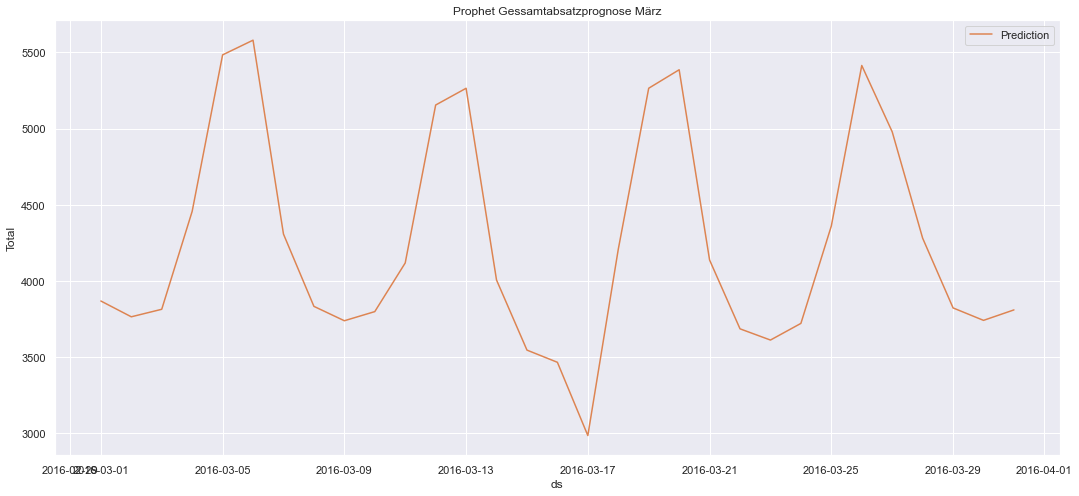

In [32]:
prophet_forecast_agg = pd.merge(forecast_food_2['yhat'], forecast_hobbies_2['yhat'], on= "ds")
prophet_forecast_agg = pd.merge(prophet_forecast_agg, forecast_household_2['yhat'], on="ds")
prophet_forecast_agg['Total'] = prophet_forecast_agg.sum(axis=1)
prophet_forecast_agg = prophet_forecast_agg.rename(columns={"yhat_x": "Food", "yhat_y": "Hobbies", "yhat": "Household"})

# Visualisierung
#data_february = data_grouped.loc['2016-02-01':'2016-02-29']
sns.lineplot(data = prophet_total_agg['Total'], label = 'Train')
sns.lineplot(data = prophet_forecast_agg['Total'], label = 'Prediction')
plt.title('Prophet Gesamtabsatzprognose März')
plt.show()

#sns.scatterplot(data = data_february['sales'], color = 'black', label = 'Test')
sns.lineplot(data = prophet_forecast_agg['Total'], color = sns.color_palette('deep').as_hex()[1], label = 'Prediction')
plt.title('Prophet Gessamtabsatzprognose März')
plt.show()

#### Speicherung der Gesamtprognose

In [ ]:
# Übertragung der Absatzprognose als .csv-Datei

prophet_forecast_agg = prophet_forecast_agg.rename(columns={'Total': 'sales'}, index={'ds': 'date'})
prophet_forecast_agg = prophet_forecast_agg['sales'].astype(int)
prophet_forecast_agg =  prophet_forecast_agg.drop(columns = ['Food', 'Hobbies', 'Household'])
display(prophet_forecast_agg)                           
prophet_forecast_agg.to_csv("Forecast.csv")

#ds wurde immer noch nicht in date umbenannt !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# To  Do's:

1. CSV-Erstellung: Wieso lässt sich die Indexspalte "ds" nicht in "date" umbenennen?
2. Doku einfügen
3. Finale Datei in Forecast.ipynb umbenennen
4. Gruppenerklärung nicht vergessen